In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-07-31 22:29:30.556618


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-9.7880)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.1169)
penalty_target_min tensor(-11.5544) penalty_target_max tensor(5.6463)
train_loss:  -8.043964761543275
valid_loss:  -8.192152389526367
h_min_tilde -11.554436 ell_tilde -8.073602287139895 kappa_tilde 0.0005359920875303314


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.4521279335021973

 2 3.553513526916504

 3 3.4348652362823486

 4 3.546613931655884

 5 3.617567300796509

 6 3.7119314670562744

 7 3.566145658493042

 8 5.063858985900879

 9 4.046013116836548

 10 5.479938745498657

 11 7.213929653167725

 12 4.601244926452637

 13 6.084772109985352

 14 4.397387504577637

 15 5.9923460483551025

 16 3.5961976051330566

 17 3.5189175605773926

 18 3.493551015853882

 19 3.711757183074951

 20 3.7979629039764404

 21 3.776400566101074

 22 4.905284881591797

 23 4.332908868789673

 24 4.026901721954346

 25 6.507290363311768

 26 3.823625087738037

 27 7.085985898971558

 28 4.4315221309661865

 29 5.950869083404541

 30 4.5834877490997314

 31 3.9417595863342285

 32 3.913461208343506

 33 4.669037580490112

 34 5.093085289001465

 35 3.951599359512329

 36 4.9672887325286865

 37 5.075240612030029

 38 5.519412994384766

 39 3.8794503211975098

 40 3.9306108951568604

 41 3.86579966545105

 42 5.545712947845459

 43 3.6753158569335938

 44 4.

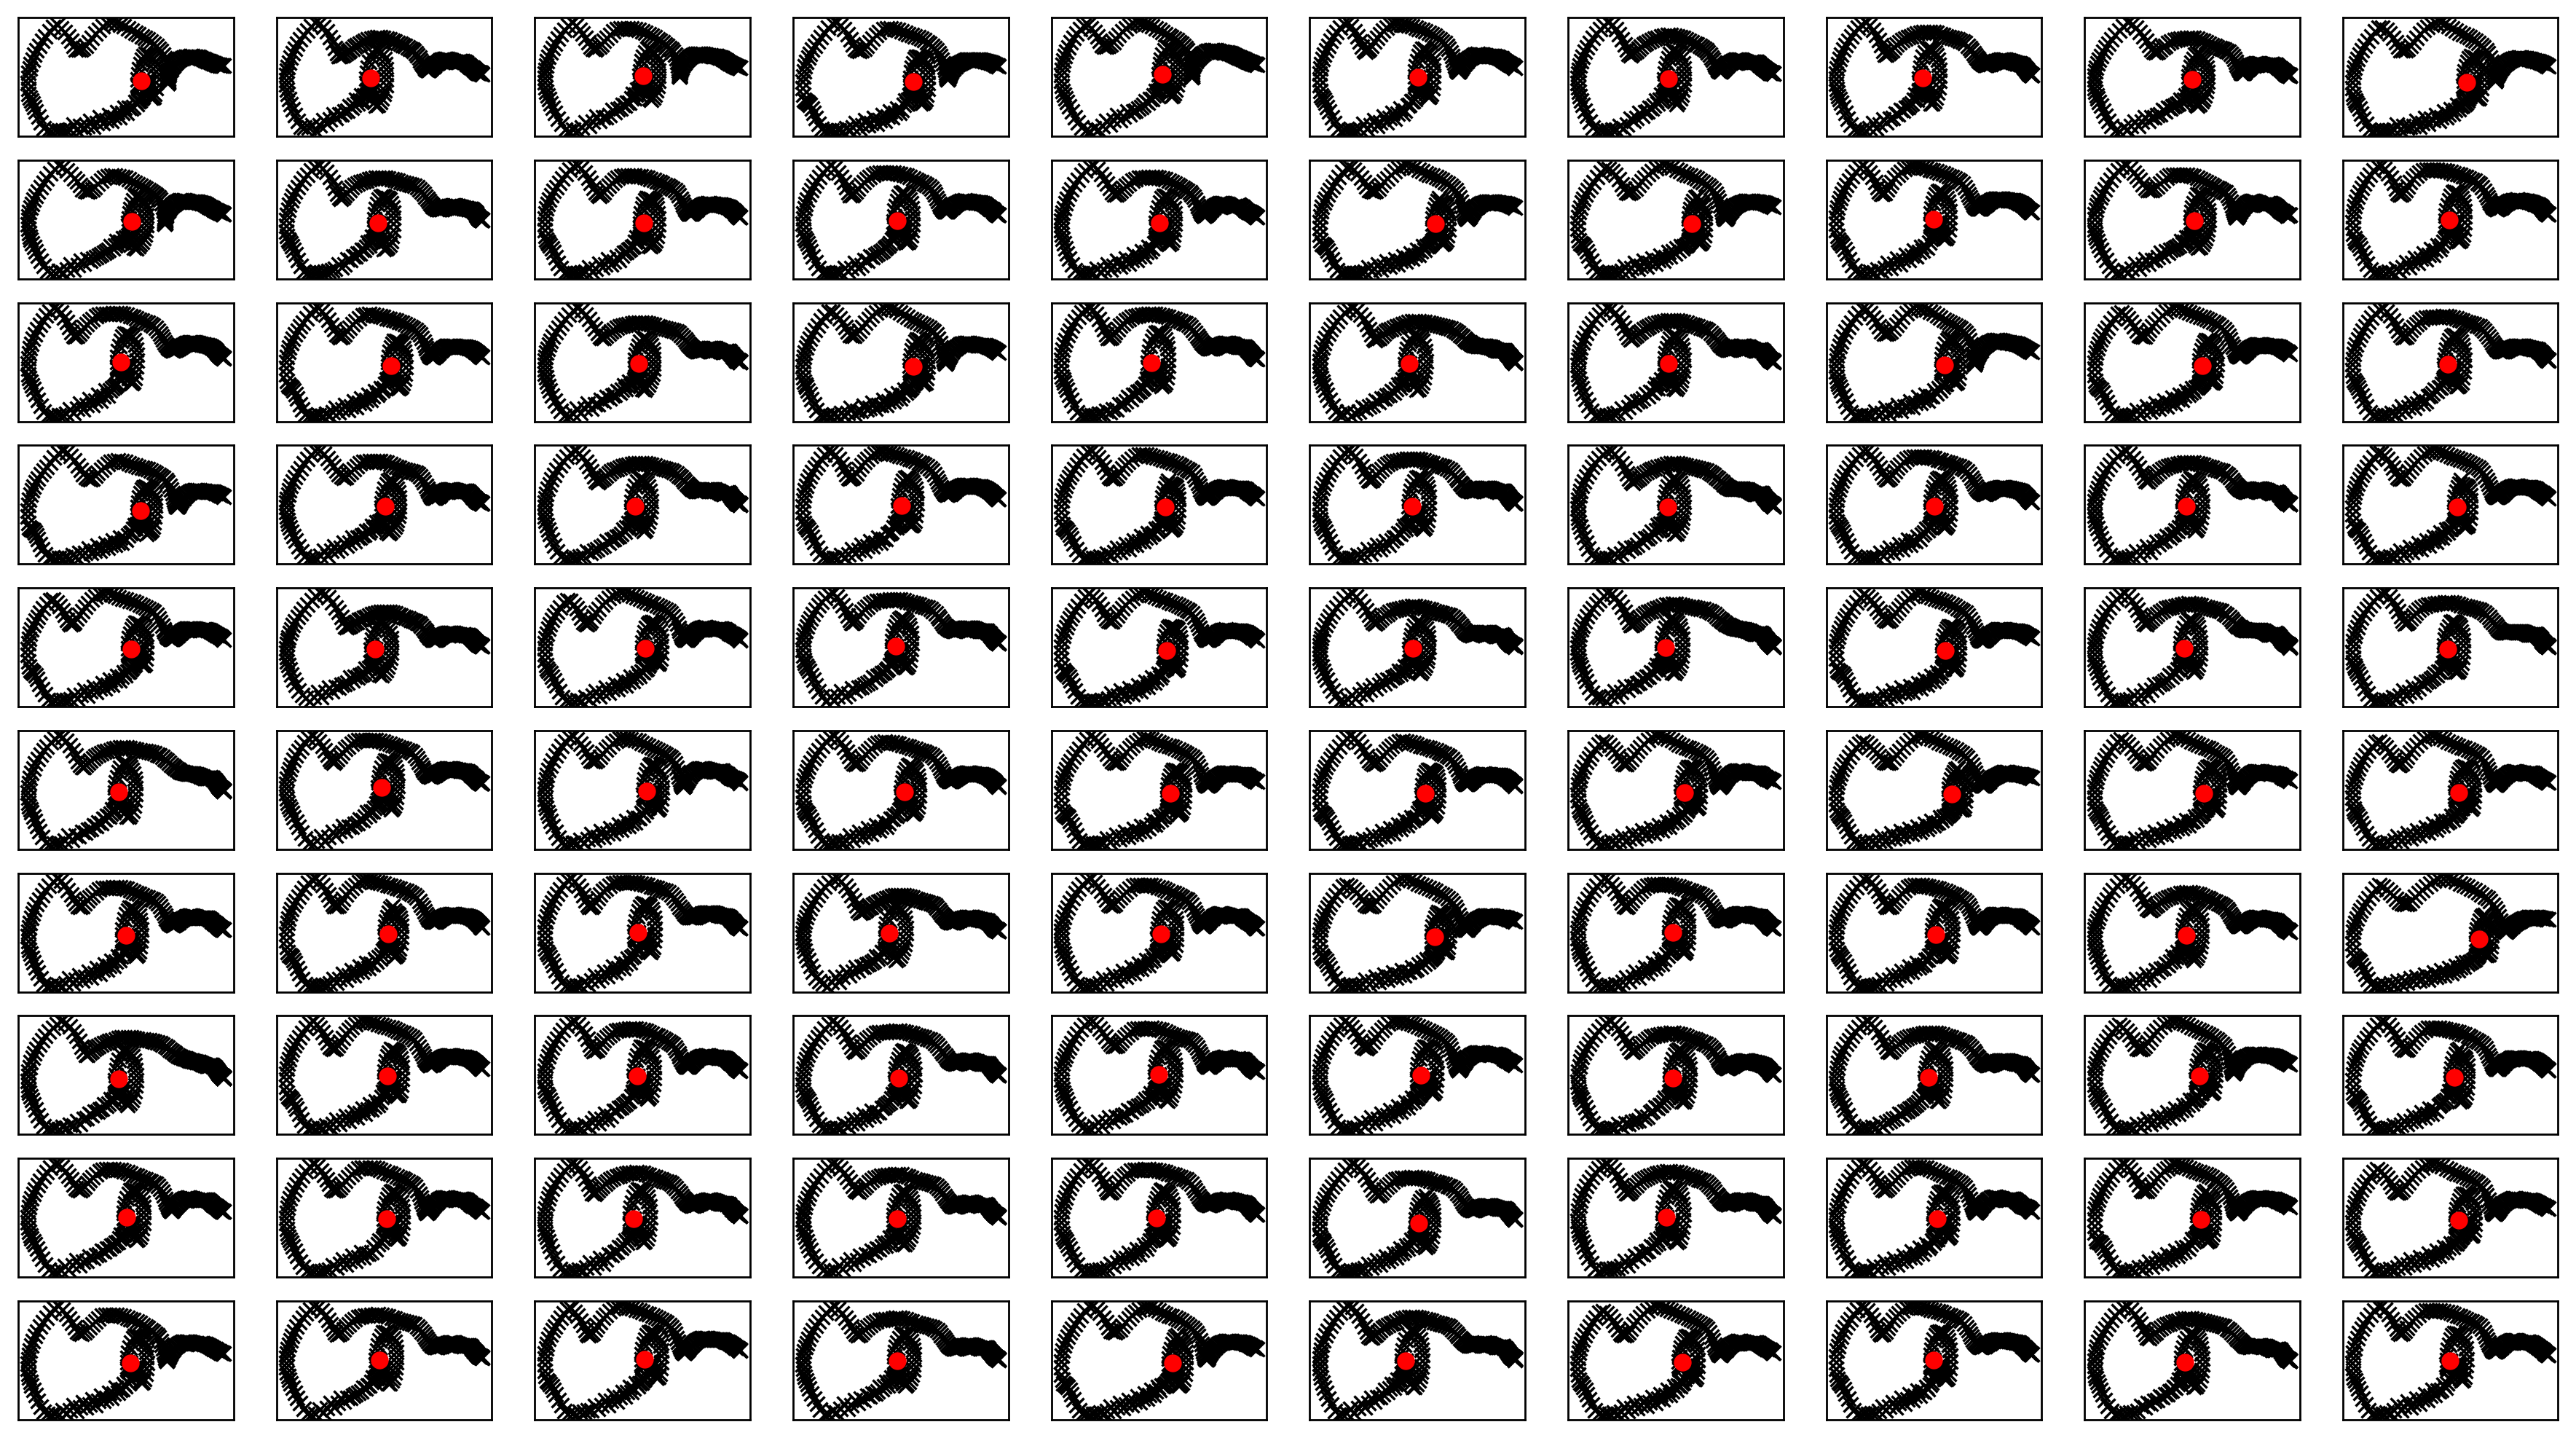

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

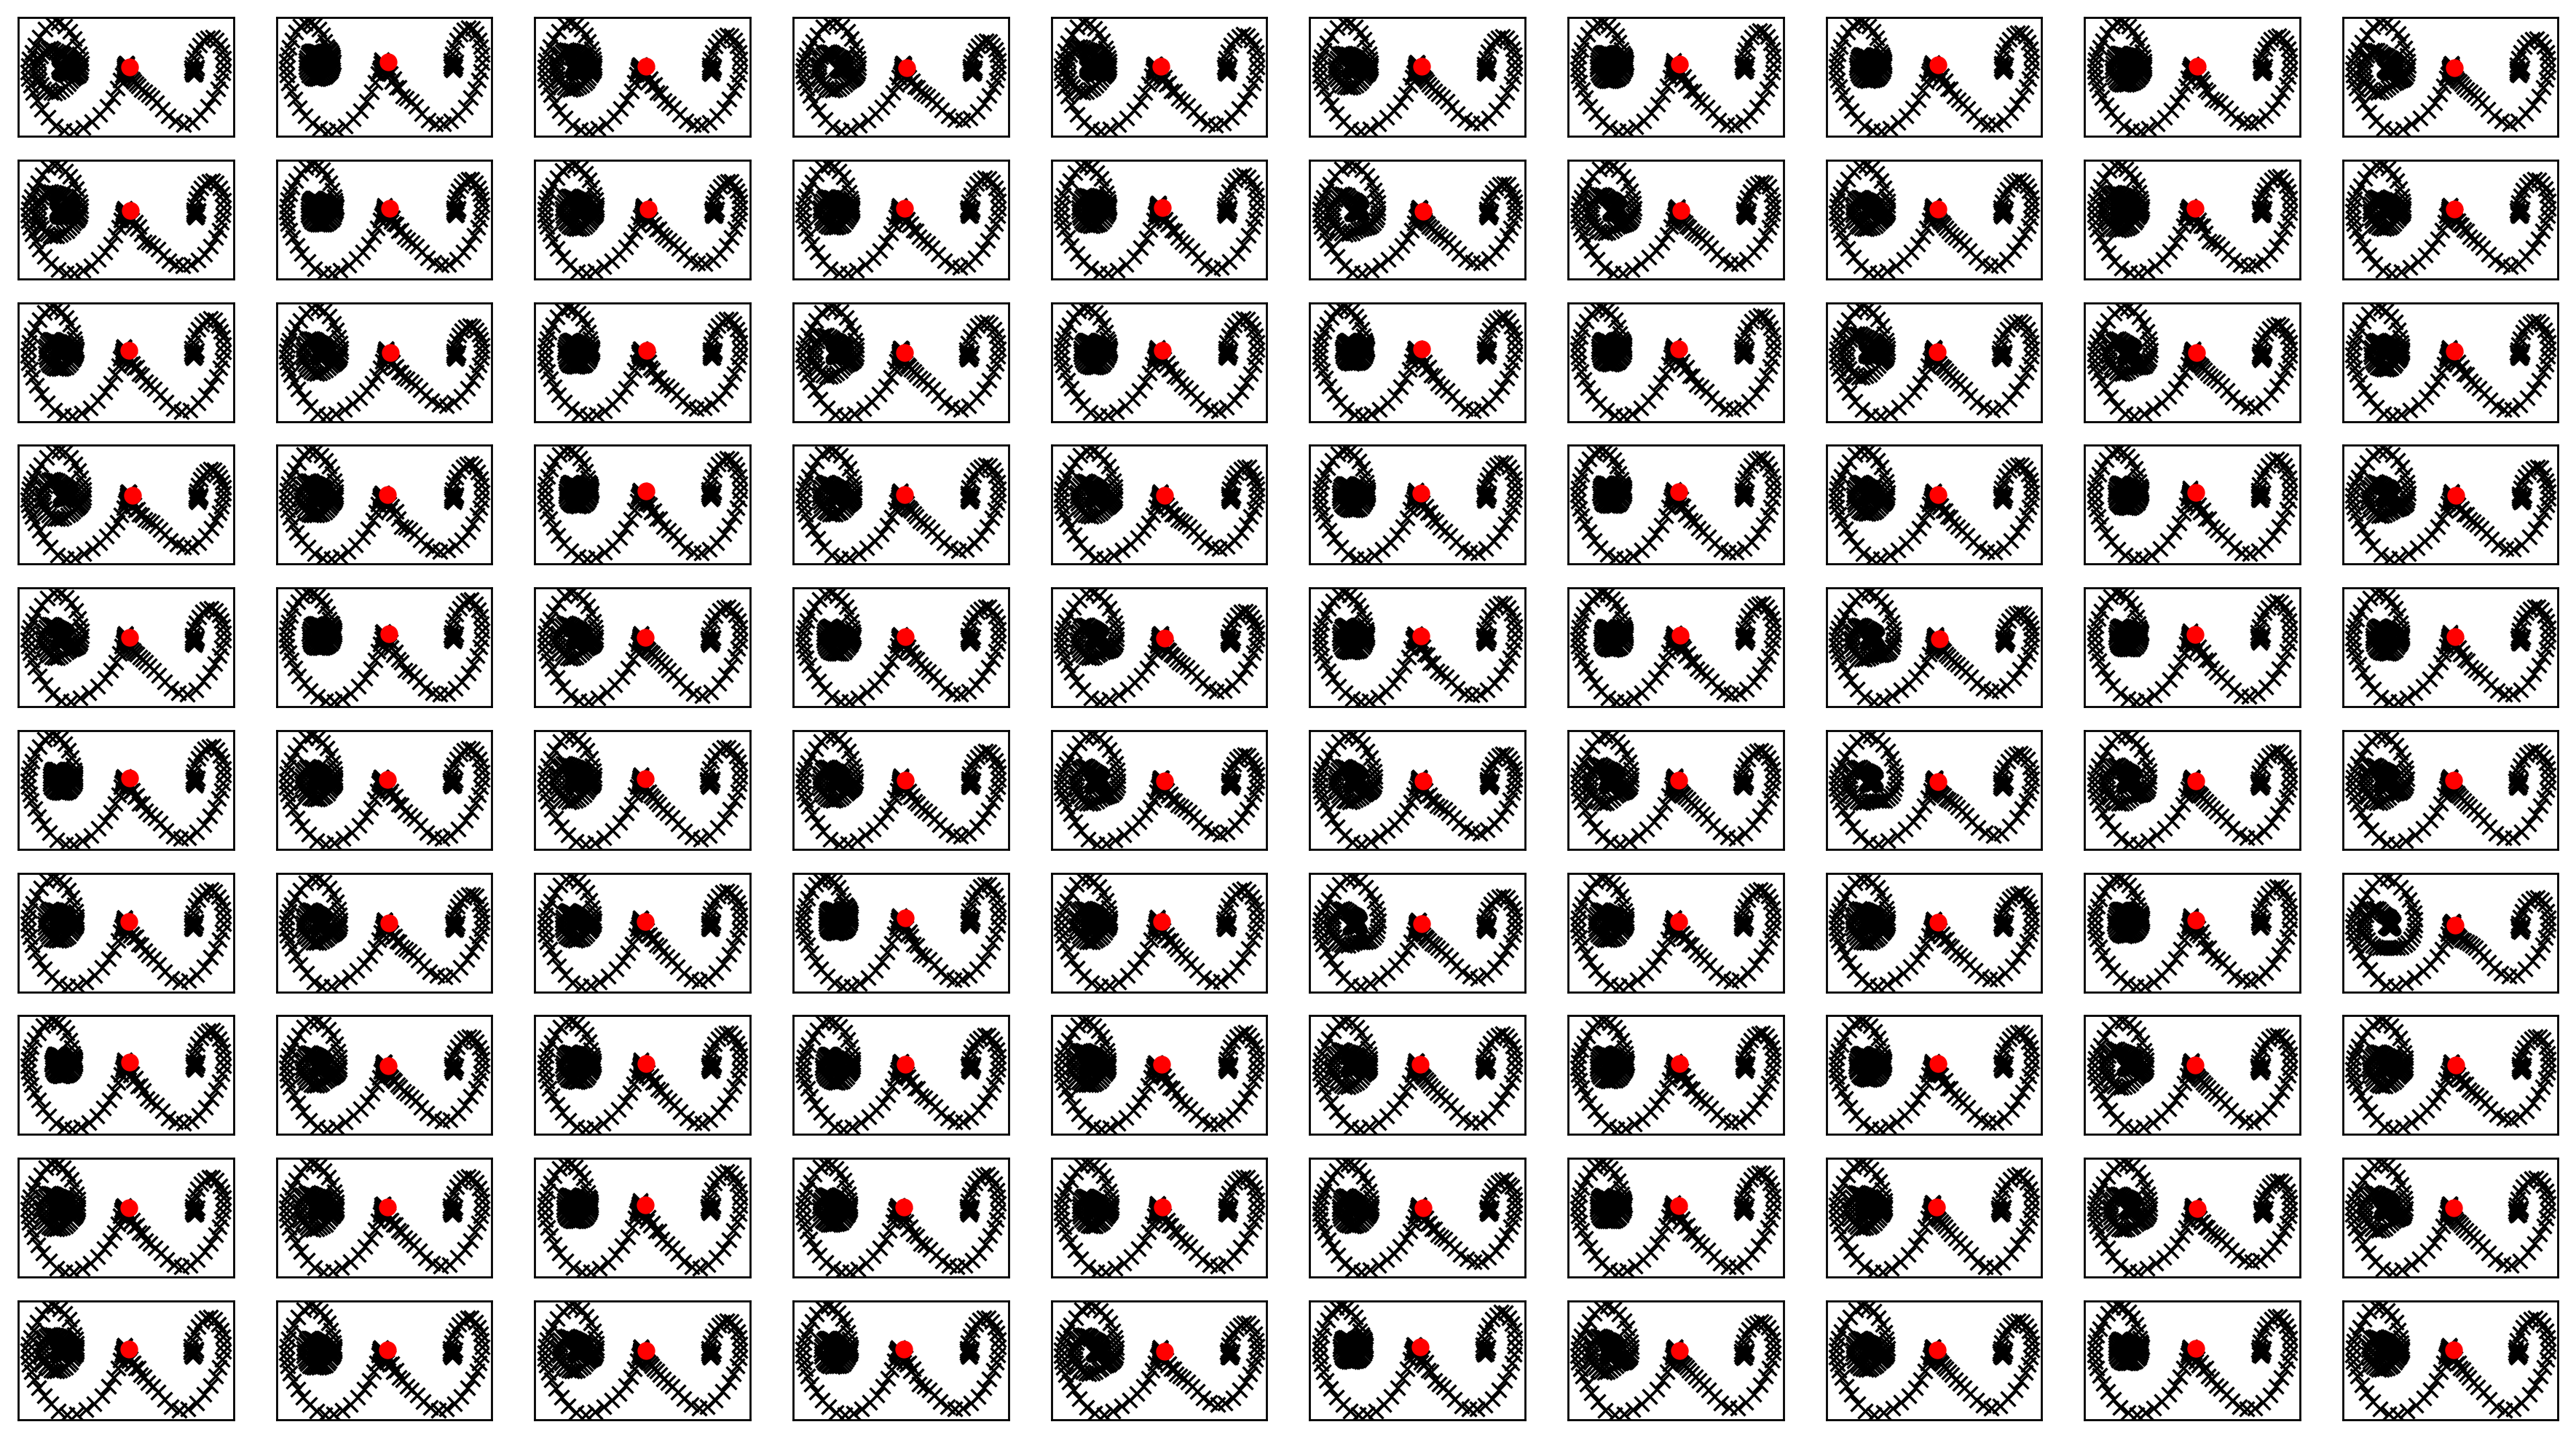

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-31 22:37:06.216640


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.37545  validloss 1.44235±0.00000  bestvalidloss 1.44235  last_update 0
train: iter 1  trainloss 1.24515  validloss 1.31488±0.00000  bestvalidloss 1.31488  last_update 0
train: iter 2  trainloss 1.08200  validloss 1.13761±0.00000  bestvalidloss 1.13761  last_update 0
train: iter 3  trainloss 0.93875  validloss 0.98788±0.00000  bestvalidloss 0.98788  last_update 0
train: iter 4  trainloss 0.82422  validloss 0.87229±0.00000  bestvalidloss 0.87229  last_update 0
train: iter 5  trainloss 0.73963  validloss 0.76150±0.00000  bestvalidloss 0.76150  last_update 0
train: iter 6  trainloss 0.67331  validloss 0.69881±0.00000  bestvalidloss 0.69881  last_update 0
train: iter 7  trainloss 0.63738  validloss 0.64939±0.00000  bestvalidloss 0.64939  last_update 0
train: iter 8  trainloss 0.61187  validloss 0.64318±0.00000  bestvalidloss 0.64318  last_update 0
train: iter 9  trainloss 0.59825  validloss 0.60940±0.00000  bestvalidloss 0.60940  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.37224  validloss 0.36767±0.00000  bestvalidloss 0.36767  last_update 0
train: iter 84  trainloss 0.36990  validloss 0.39257±0.00000  bestvalidloss 0.36767  last_update 1
train: iter 85  trainloss 0.37292  validloss 0.36781±0.00000  bestvalidloss 0.36767  last_update 2
train: iter 86  trainloss 0.36831  validloss 0.36992±0.00000  bestvalidloss 0.36767  last_update 3
train: iter 87  trainloss 0.36716  validloss 0.37390±0.00000  bestvalidloss 0.36767  last_update 4
train: iter 88  trainloss 0.36364  validloss 0.37044±0.00000  bestvalidloss 0.36767  last_update 5
train: iter 89  trainloss 0.36493  validloss 0.36126±0.00000  bestvalidloss 0.36126  last_update 0
train: iter 90  trainloss 0.36271  validloss 0.38157±0.00000  bestvalidloss 0.36126  last_update 1
train: iter 91  trainloss 0.35958  validloss 0.36854±0.00000  bestvalidloss 0.36126  last_update 2
train: iter 92  trainloss 0.36177  validloss 0.37254±0.00000  bestvalidloss 0.36126  last_update 3
train: ite

train: iter 166  trainloss 0.31735  validloss 0.32283±0.00000  bestvalidloss 0.31919  last_update 2
train: iter 167  trainloss 0.31309  validloss 0.33084±0.00000  bestvalidloss 0.31919  last_update 3
train: iter 168  trainloss 0.31236  validloss 0.32202±0.00000  bestvalidloss 0.31919  last_update 4
train: iter 169  trainloss 0.31365  validloss 0.33048±0.00000  bestvalidloss 0.31919  last_update 5
train: iter 170  trainloss 0.31907  validloss 0.36424±0.00000  bestvalidloss 0.31919  last_update 6
train: iter 171  trainloss 0.31606  validloss 0.32591±0.00000  bestvalidloss 0.31919  last_update 7
train: iter 172  trainloss 0.31527  validloss 0.32590±0.00000  bestvalidloss 0.31919  last_update 8
train: iter 173  trainloss 0.32081  validloss 0.33610±0.00000  bestvalidloss 0.31919  last_update 9
train: iter 174  trainloss 0.31698  validloss 0.31559±0.00000  bestvalidloss 0.31559  last_update 0
train: iter 175  trainloss 0.31309  validloss 0.32538±0.00000  bestvalidloss 0.31559  last_update 1


train: iter 248  trainloss 0.28697  validloss 0.29800±0.00000  bestvalidloss 0.29468  last_update 3
train: iter 249  trainloss 0.28442  validloss 0.29621±0.00000  bestvalidloss 0.29468  last_update 4
train: iter 250  trainloss 0.28653  validloss 0.29794±0.00000  bestvalidloss 0.29468  last_update 5
train: iter 251  trainloss 0.28829  validloss 0.30268±0.00000  bestvalidloss 0.29468  last_update 6
train: iter 252  trainloss 0.28873  validloss 0.30948±0.00000  bestvalidloss 0.29468  last_update 7
train: iter 253  trainloss 0.28489  validloss 0.30815±0.00000  bestvalidloss 0.29468  last_update 8
train: iter 254  trainloss 0.29214  validloss 0.32001±0.00000  bestvalidloss 0.29468  last_update 9
train: iter 255  trainloss 0.28396  validloss 0.29541±0.00000  bestvalidloss 0.29468  last_update 10
train: iter 256  trainloss 0.28611  validloss 0.29554±0.00000  bestvalidloss 0.29468  last_update 11
train: iter 257  trainloss 0.28734  validloss 0.29588±0.00000  bestvalidloss 0.29468  last_update 

train: iter 330  trainloss 0.26205  validloss 0.27422±0.00000  bestvalidloss 0.27422  last_update 0
train: iter 331  trainloss 0.26379  validloss 0.27676±0.00000  bestvalidloss 0.27422  last_update 1
train: iter 332  trainloss 0.26836  validloss 0.27342±0.00000  bestvalidloss 0.27342  last_update 0
train: iter 333  trainloss 0.26160  validloss 0.28957±0.00000  bestvalidloss 0.27342  last_update 1
train: iter 334  trainloss 0.26395  validloss 0.27194±0.00000  bestvalidloss 0.27194  last_update 0
train: iter 335  trainloss 0.26085  validloss 0.28332±0.00000  bestvalidloss 0.27194  last_update 1
train: iter 336  trainloss 0.26213  validloss 0.27154±0.00000  bestvalidloss 0.27154  last_update 0
train: iter 337  trainloss 0.25833  validloss 0.27972±0.00000  bestvalidloss 0.27154  last_update 1
train: iter 338  trainloss 0.26237  validloss 0.27745±0.00000  bestvalidloss 0.27154  last_update 2
train: iter 339  trainloss 0.26824  validloss 0.28485±0.00000  bestvalidloss 0.27154  last_update 3


train: iter 412  trainloss 0.24622  validloss 0.26867±0.00000  bestvalidloss 0.26071  last_update 3
train: iter 413  trainloss 0.24930  validloss 0.26315±0.00000  bestvalidloss 0.26071  last_update 4
train: iter 414  trainloss 0.24483  validloss 0.26891±0.00000  bestvalidloss 0.26071  last_update 5
train: iter 415  trainloss 0.24655  validloss 0.26603±0.00000  bestvalidloss 0.26071  last_update 6
train: iter 416  trainloss 0.24558  validloss 0.26512±0.00000  bestvalidloss 0.26071  last_update 7
train: iter 417  trainloss 0.24629  validloss 0.27675±0.00000  bestvalidloss 0.26071  last_update 8
train: iter 418  trainloss 0.24659  validloss 0.27371±0.00000  bestvalidloss 0.26071  last_update 9
train: iter 419  trainloss 0.24696  validloss 0.26260±0.00000  bestvalidloss 0.26071  last_update 10
train: iter 420  trainloss 0.24887  validloss 0.26588±0.00000  bestvalidloss 0.26071  last_update 11
train: iter 421  trainloss 0.24535  validloss 0.26860±0.00000  bestvalidloss 0.26071  last_update 

train: iter 494  trainloss 0.23602  validloss 0.25121±0.00000  bestvalidloss 0.25121  last_update 0
train: iter 495  trainloss 0.23706  validloss 0.26760±0.00000  bestvalidloss 0.25121  last_update 1
train: iter 496  trainloss 0.23725  validloss 0.25742±0.00000  bestvalidloss 0.25121  last_update 2
train: iter 497  trainloss 0.23269  validloss 0.25666±0.00000  bestvalidloss 0.25121  last_update 3
train: iter 498  trainloss 0.23588  validloss 0.26335±0.00000  bestvalidloss 0.25121  last_update 4
train: iter 499  trainloss 0.23336  validloss 0.26324±0.00000  bestvalidloss 0.25121  last_update 5
train: iter 500  trainloss 0.24124  validloss 0.25827±0.00000  bestvalidloss 0.25121  last_update 6
train: iter 501  trainloss 0.23923  validloss 0.26483±0.00000  bestvalidloss 0.25121  last_update 7
train: iter 502  trainloss 0.23239  validloss 0.25481±0.00000  bestvalidloss 0.25121  last_update 8
train: iter 503  trainloss 0.23594  validloss 0.27394±0.00000  bestvalidloss 0.25121  last_update 9


train: iter 576  trainloss 0.22353  validloss 0.28429±0.00000  bestvalidloss 0.24976  last_update 30
train: iter 577  trainloss 0.22824  validloss 0.26940±0.00000  bestvalidloss 0.24976  last_update 31
train: iter 578  trainloss 0.22726  validloss 0.26270±0.00000  bestvalidloss 0.24976  last_update 32
train: iter 579  trainloss 0.23153  validloss 0.25069±0.00000  bestvalidloss 0.24976  last_update 33
train: iter 580  trainloss 0.22739  validloss 0.26812±0.00000  bestvalidloss 0.24976  last_update 34
train: iter 581  trainloss 0.22475  validloss 0.25134±0.00000  bestvalidloss 0.24976  last_update 35
train: iter 582  trainloss 0.22759  validloss 0.26110±0.00000  bestvalidloss 0.24976  last_update 36
train: iter 583  trainloss 0.22398  validloss 0.25183±0.00000  bestvalidloss 0.24976  last_update 37
train: iter 584  trainloss 0.22689  validloss 0.25098±0.00000  bestvalidloss 0.24976  last_update 38
train: iter 585  trainloss 0.22420  validloss 0.27724±0.00000  bestvalidloss 0.24976  last_

train: iter 658  trainloss 0.22780  validloss 0.27083±0.00000  bestvalidloss 0.24692  last_update 57
train: iter 659  trainloss 0.22374  validloss 0.27019±0.00000  bestvalidloss 0.24692  last_update 58
train: iter 660  trainloss 0.21688  validloss 0.25617±0.00000  bestvalidloss 0.24692  last_update 59
train: iter 661  trainloss 0.22047  validloss 0.25808±0.00000  bestvalidloss 0.24692  last_update 60
train: iter 662  trainloss 0.22266  validloss 0.26640±0.00000  bestvalidloss 0.24692  last_update 61
train: iter 663  trainloss 0.21564  validloss 0.26108±0.00000  bestvalidloss 0.24692  last_update 62
train: iter 664  trainloss 0.21846  validloss 0.25119±0.00000  bestvalidloss 0.24692  last_update 63
train: iter 665  trainloss 0.21688  validloss 0.25116±0.00000  bestvalidloss 0.24692  last_update 64
train: iter 666  trainloss 0.21789  validloss 0.25349±0.00000  bestvalidloss 0.24692  last_update 65
train: iter 667  trainloss 0.21650  validloss 0.25644±0.00000  bestvalidloss 0.24692  last_

train_loss:  -3.5732132865309714
valid_loss:  -4.643022693514824
weight_alpha 1.0 h_min_tilde -11.554436 ell_tilde -3.787175167927742 kappa_tilde 0.000358811259571436
train_loss:  -2.786190311956406
valid_loss:  -3.104018587112427
weight_alpha 0.1 h_min_tilde -11.554436 ell_tilde -2.84975596698761 kappa_tilde 0.0003389406053472773


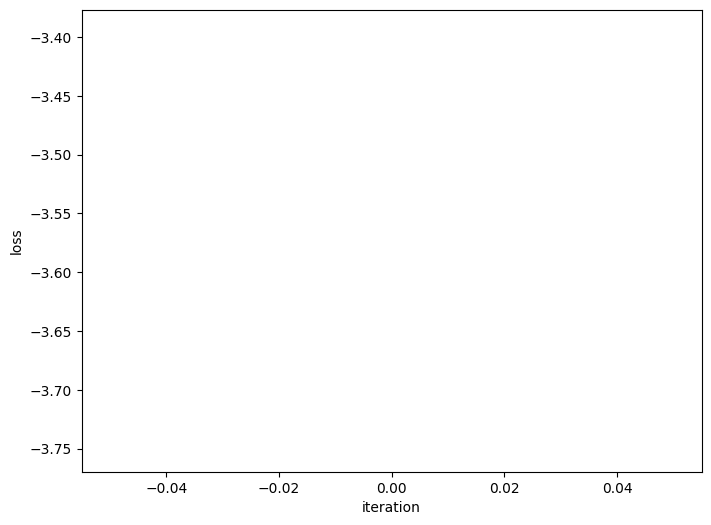

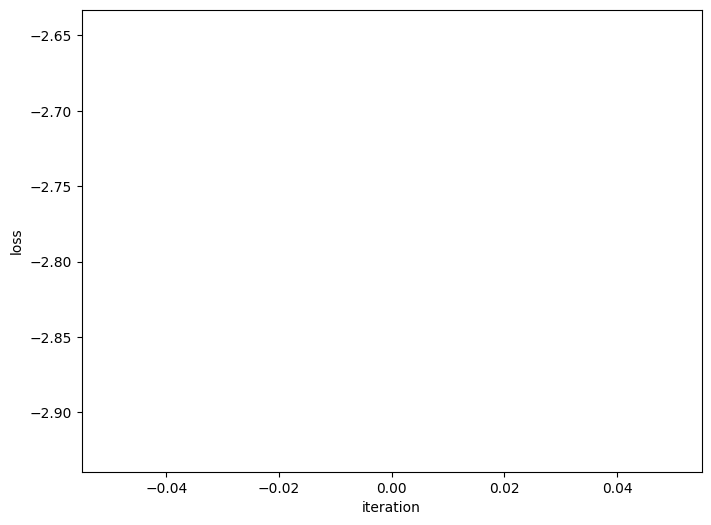

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -536.64932  validloss -620.73589±0.00000  bestvalidloss -620.73589  last_update 0
train: iter 1  trainloss -556.61018  validloss -618.68747±0.00000  bestvalidloss -620.73589  last_update 1
train: iter 2  trainloss -547.21814  validloss -610.55314±0.00000  bestvalidloss -620.73589  last_update 2
train: iter 3  trainloss -537.15036  validloss -572.46062±0.00000  bestvalidloss -620.73589  last_update 3
train: iter 4  trainloss -549.68306  validloss -601.69077±0.00000  bestvalidloss -620.73589  last_update 4
train: iter 5  trainloss -552.22287  validloss -609.46320±0.00000  bestvalidloss -620.73589  last_update 5
train: iter 6  trainloss -485.46882  validloss -621.11248±0.00000  bestvalidloss -621.11248  last_update 0
train: iter 7  trainloss -545.11275  validloss -604.22871±0.00000  bestvalidloss -621.11248  last_update 1
train: iter 8  trainloss -534.42760  validloss -584.87852±0.00000  bestvalidloss -621.11248  last_u

train: iter 76  trainloss -581.02293  validloss -632.88334±0.00000  bestvalidloss -639.25276  last_update 21
train: iter 77  trainloss -568.09255  validloss -613.28775±0.00000  bestvalidloss -639.25276  last_update 22
train: iter 78  trainloss -581.27957  validloss -621.99624±0.00000  bestvalidloss -639.25276  last_update 23
train: iter 79  trainloss -565.67344  validloss -630.94615±0.00000  bestvalidloss -639.25276  last_update 24
train: iter 80  trainloss -581.52974  validloss -619.74737±0.00000  bestvalidloss -639.25276  last_update 25
train: iter 81  trainloss -589.94052  validloss -632.51551±0.00000  bestvalidloss -639.25276  last_update 26
train: iter 82  trainloss -568.83239  validloss -641.64704±0.00000  bestvalidloss -641.64704  last_update 0
train: iter 83  trainloss -528.68229  validloss -603.72264±0.00000  bestvalidloss -641.64704  last_update 1
train: iter 84  trainloss -569.03811  validloss -590.10634±0.00000  bestvalidloss -641.64704  last_update 2
train: iter 85  trainl

train: iter 151  trainloss -592.12505  validloss -627.10631±0.00000  bestvalidloss -645.24125  last_update 16
train: iter 152  trainloss -603.62813  validloss -632.42178±0.00000  bestvalidloss -645.24125  last_update 17
train: iter 153  trainloss -609.30930  validloss -643.11429±0.00000  bestvalidloss -645.24125  last_update 18
train: iter 154  trainloss -603.97594  validloss -642.67284±0.00000  bestvalidloss -645.24125  last_update 19
train: iter 155  trainloss -555.23221  validloss -617.67744±0.00000  bestvalidloss -645.24125  last_update 20
train: iter 156  trainloss -597.46499  validloss -626.50012±0.00000  bestvalidloss -645.24125  last_update 21
train: iter 157  trainloss -605.17958  validloss -645.68355±0.00000  bestvalidloss -645.68355  last_update 0
train: iter 158  trainloss -598.10372  validloss -613.11364±0.00000  bestvalidloss -645.68355  last_update 1
train: iter 159  trainloss -605.07570  validloss -638.22393±0.00000  bestvalidloss -645.68355  last_update 2
train: iter 1

train: iter 226  trainloss -620.63830  validloss -647.45515±0.00000  bestvalidloss -649.19614  last_update 46
train: iter 227  trainloss -614.79707  validloss -653.96361±0.00000  bestvalidloss -653.96361  last_update 0
train: iter 228  trainloss -572.12488  validloss -625.52253±0.00000  bestvalidloss -653.96361  last_update 1
train: iter 229  trainloss -615.62350  validloss -625.02608±0.00000  bestvalidloss -653.96361  last_update 2
train: iter 230  trainloss -620.99901  validloss -648.74793±0.00000  bestvalidloss -653.96361  last_update 3
train: iter 231  trainloss -621.04563  validloss -650.58307±0.00000  bestvalidloss -653.96361  last_update 4
train: iter 232  trainloss -607.23617  validloss -599.15627±0.00000  bestvalidloss -653.96361  last_update 5
train: iter 233  trainloss -622.93536  validloss -630.78679±0.00000  bestvalidloss -653.96361  last_update 6
train: iter 234  trainloss -627.14375  validloss -640.71776±0.00000  bestvalidloss -653.96361  last_update 7
train: iter 235  t

train: iter 301  trainloss -636.65357  validloss -638.69303±0.00000  bestvalidloss -658.74571  last_update 14
train: iter 302  trainloss -623.07431  validloss -653.17011±0.00000  bestvalidloss -658.74571  last_update 15
train: iter 303  trainloss -630.29331  validloss -641.65283±0.00000  bestvalidloss -658.74571  last_update 16
train: iter 304  trainloss -637.74934  validloss -652.98065±0.00000  bestvalidloss -658.74571  last_update 17
train: iter 305  trainloss -632.45994  validloss -658.43728±0.00000  bestvalidloss -658.74571  last_update 18
train: iter 306  trainloss -602.02900  validloss -621.59200±0.00000  bestvalidloss -658.74571  last_update 19
train: iter 307  trainloss -632.32526  validloss -649.04197±0.00000  bestvalidloss -658.74571  last_update 20
train: iter 308  trainloss -640.93828  validloss -655.64864±0.00000  bestvalidloss -658.74571  last_update 21
train: iter 309  trainloss -634.19749  validloss -651.89901±0.00000  bestvalidloss -658.74571  last_update 22
train: ite

train: iter 376  trainloss -643.68429  validloss -664.25228±0.00000  bestvalidloss -666.61864  last_update 62
train: iter 377  trainloss -643.92004  validloss -645.99231±0.00000  bestvalidloss -666.61864  last_update 63
train: iter 378  trainloss -636.07560  validloss -659.19679±0.00000  bestvalidloss -666.61864  last_update 64
train: iter 379  trainloss -626.41280  validloss -653.83840±0.00000  bestvalidloss -666.61864  last_update 65
train: iter 380  trainloss -635.13586  validloss -645.19983±0.00000  bestvalidloss -666.61864  last_update 66
train: iter 381  trainloss -634.56033  validloss -648.82568±0.00000  bestvalidloss -666.61864  last_update 67
train: iter 382  trainloss -617.38454  validloss -620.09989±0.00000  bestvalidloss -666.61864  last_update 68
train: iter 383  trainloss -642.06363  validloss -651.22229±0.00000  bestvalidloss -666.61864  last_update 69
train: iter 384  trainloss -641.65675  validloss -655.51252±0.00000  bestvalidloss -666.61864  last_update 70
train: ite

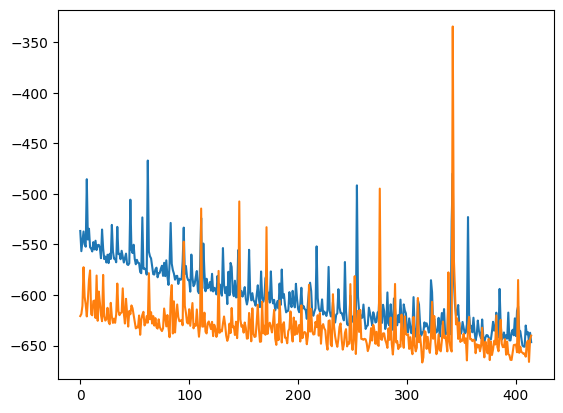

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-31 23:06:10.855571


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.63144  validloss 0.66506±0.00000  bestvalidloss 0.66506  last_update 0
train: iter 1  trainloss 0.53813  validloss 0.57927±0.00000  bestvalidloss 0.57927  last_update 0
train: iter 2  trainloss 0.47283  validloss 0.52170±0.00000  bestvalidloss 0.52170  last_update 0
train: iter 3  trainloss 0.44052  validloss 0.49256±0.00000  bestvalidloss 0.49256  last_update 0
train: iter 4  trainloss 0.42048  validloss 0.46838±0.00000  bestvalidloss 0.46838  last_update 0
train: iter 5  trainloss 0.40956  validloss 0.45176±0.00000  bestvalidloss 0.45176  last_update 0
train: iter 6  trainloss 0.39949  validloss 0.44304±0.00000  bestvalidloss 0.44304  last_update 0
train: iter 7  trainloss 0.40150  validloss 0.44034±0.00000  bestvalidloss 0.44034  last_update 0
train: iter 8  trainloss 0.38940  validloss 0.42607±0.00000  bestvalidloss 0.42607  last_update 0
train: iter 9  trainloss 0.38338  validloss 0.43022±0.00000  bestvalidloss 0.42607  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.30373  validloss 0.40614±0.00000  bestvalidloss 0.40104  last_update 4
train: iter 84  trainloss 0.30561  validloss 0.42282±0.00000  bestvalidloss 0.40104  last_update 5
train: iter 85  trainloss 0.30715  validloss 0.40800±0.00000  bestvalidloss 0.40104  last_update 6
train: iter 86  trainloss 0.30150  validloss 0.39935±0.00000  bestvalidloss 0.39935  last_update 0
train: iter 87  trainloss 0.30067  validloss 0.40477±0.00000  bestvalidloss 0.39935  last_update 1
train: iter 88  trainloss 0.30042  validloss 0.39948±0.00000  bestvalidloss 0.39935  last_update 2
train: iter 89  trainloss 0.29967  validloss 0.40434±0.00000  bestvalidloss 0.39935  last_update 3
train: iter 90  trainloss 0.30815  validloss 0.40780±0.00000  bestvalidloss 0.39935  last_update 4
train: iter 91  trainloss 0.30385  validloss 0.39801±0.00000  bestvalidloss 0.39801  last_update 0
train: iter 92  trainloss 0.30060  validloss 0.40560±0.00000  bestvalidloss 0.39801  last_update 1
train: ite

train: iter 165  trainloss 0.28284  validloss 0.38784±0.00000  bestvalidloss 0.38720  last_update 5
train: iter 166  trainloss 0.28634  validloss 0.39478±0.00000  bestvalidloss 0.38720  last_update 6
train: iter 167  trainloss 0.28059  validloss 0.39793±0.00000  bestvalidloss 0.38720  last_update 7
train: iter 168  trainloss 0.28046  validloss 0.39172±0.00000  bestvalidloss 0.38720  last_update 8
train: iter 169  trainloss 0.28243  validloss 0.39582±0.00000  bestvalidloss 0.38720  last_update 9
train: iter 170  trainloss 0.27919  validloss 0.40100±0.00000  bestvalidloss 0.38720  last_update 10
train: iter 171  trainloss 0.28116  validloss 0.41045±0.00000  bestvalidloss 0.38720  last_update 11
train: iter 172  trainloss 0.27947  validloss 0.39218±0.00000  bestvalidloss 0.38720  last_update 12
train: iter 173  trainloss 0.28301  validloss 0.41376±0.00000  bestvalidloss 0.38720  last_update 13
train: iter 174  trainloss 0.27999  validloss 0.39697±0.00000  bestvalidloss 0.38720  last_updat

train: iter 247  trainloss 0.26974  validloss 0.39572±0.00000  bestvalidloss 0.38455  last_update 30
train: iter 248  trainloss 0.26932  validloss 0.39036±0.00000  bestvalidloss 0.38455  last_update 31
train: iter 249  trainloss 0.26688  validloss 0.38739±0.00000  bestvalidloss 0.38455  last_update 32
train: iter 250  trainloss 0.26630  validloss 0.38752±0.00000  bestvalidloss 0.38455  last_update 33
train: iter 251  trainloss 0.26853  validloss 0.39463±0.00000  bestvalidloss 0.38455  last_update 34
train: iter 252  trainloss 0.26753  validloss 0.39231±0.00000  bestvalidloss 0.38455  last_update 35
train: iter 253  trainloss 0.26534  validloss 0.38891±0.00000  bestvalidloss 0.38455  last_update 36
train: iter 254  trainloss 0.26798  validloss 0.39386±0.00000  bestvalidloss 0.38455  last_update 37
train: iter 255  trainloss 0.26799  validloss 0.38677±0.00000  bestvalidloss 0.38455  last_update 38
train: iter 256  trainloss 0.26573  validloss 0.39132±0.00000  bestvalidloss 0.38455  last_

train: iter 329  trainloss 0.25230  validloss 0.38594±0.00000  bestvalidloss 0.38138  last_update 2
train: iter 330  trainloss 0.25529  validloss 0.39155±0.00000  bestvalidloss 0.38138  last_update 3
train: iter 331  trainloss 0.25692  validloss 0.38880±0.00000  bestvalidloss 0.38138  last_update 4
train: iter 332  trainloss 0.25359  validloss 0.38610±0.00000  bestvalidloss 0.38138  last_update 5
train: iter 333  trainloss 0.25845  validloss 0.38664±0.00000  bestvalidloss 0.38138  last_update 6
train: iter 334  trainloss 0.25570  validloss 0.39973±0.00000  bestvalidloss 0.38138  last_update 7
train: iter 335  trainloss 0.25308  validloss 0.39986±0.00000  bestvalidloss 0.38138  last_update 8
train: iter 336  trainloss 0.25323  validloss 0.38788±0.00000  bestvalidloss 0.38138  last_update 9
train: iter 337  trainloss 0.25391  validloss 0.38704±0.00000  bestvalidloss 0.38138  last_update 10
train: iter 338  trainloss 0.25730  validloss 0.39327±0.00000  bestvalidloss 0.38138  last_update 1

train: iter 411  trainloss 0.24293  validloss 0.38197±0.00000  bestvalidloss 0.37548  last_update 8
train: iter 412  trainloss 0.24514  validloss 0.39891±0.00000  bestvalidloss 0.37548  last_update 9
train: iter 413  trainloss 0.24392  validloss 0.38860±0.00000  bestvalidloss 0.37548  last_update 10
train: iter 414  trainloss 0.24665  validloss 0.38954±0.00000  bestvalidloss 0.37548  last_update 11
train: iter 415  trainloss 0.24313  validloss 0.38442±0.00000  bestvalidloss 0.37548  last_update 12
train: iter 416  trainloss 0.24305  validloss 0.39979±0.00000  bestvalidloss 0.37548  last_update 13
train: iter 417  trainloss 0.24262  validloss 0.39042±0.00000  bestvalidloss 0.37548  last_update 14
train: iter 418  trainloss 0.24077  validloss 0.38723±0.00000  bestvalidloss 0.37548  last_update 15
train: iter 419  trainloss 0.24529  validloss 0.38568±0.00000  bestvalidloss 0.37548  last_update 16
train: iter 420  trainloss 0.24474  validloss 0.38891±0.00000  bestvalidloss 0.37548  last_up

train: iter 493  trainloss 0.23672  validloss 0.38919±0.00000  bestvalidloss 0.37548  last_update 90
train: iter 494  trainloss 0.23313  validloss 0.39184±0.00000  bestvalidloss 0.37548  last_update 91
train: iter 495  trainloss 0.23660  validloss 0.38698±0.00000  bestvalidloss 0.37548  last_update 92
train: iter 496  trainloss 0.23512  validloss 0.39123±0.00000  bestvalidloss 0.37548  last_update 93
train: iter 497  trainloss 0.23854  validloss 0.39323±0.00000  bestvalidloss 0.37548  last_update 94
train: iter 498  trainloss 0.23554  validloss 0.41045±0.00000  bestvalidloss 0.37548  last_update 95
train: iter 499  trainloss 0.23204  validloss 0.38607±0.00000  bestvalidloss 0.37548  last_update 96
train: iter 500  trainloss 0.23404  validloss 0.38912±0.00000  bestvalidloss 0.37548  last_update 97
train: iter 501  trainloss 0.23413  validloss 0.38960±0.00000  bestvalidloss 0.37548  last_update 98
train: iter 502  trainloss 0.23378  validloss 0.39295±0.00000  bestvalidloss 0.37548  last_

train_loss:  -6.754089688083529
valid_loss:  -11.72943193397522
weight_alpha 1.0 h_min_tilde -11.527159 ell_tilde -7.749158137261868 kappa_tilde 0.0005144805830189816
train_loss:  -3.11260546541214
valid_loss:  -3.2736151279449457
weight_alpha 0.1 h_min_tilde -11.527159 ell_tilde -3.144807397918701 kappa_tilde 0.00034539581412138383


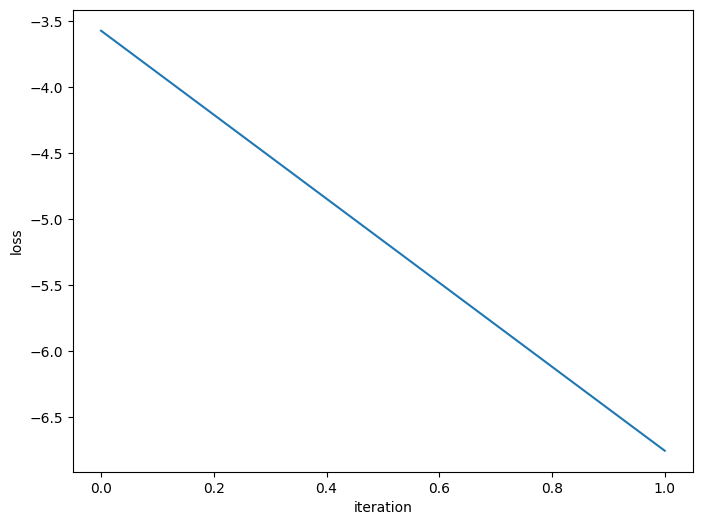

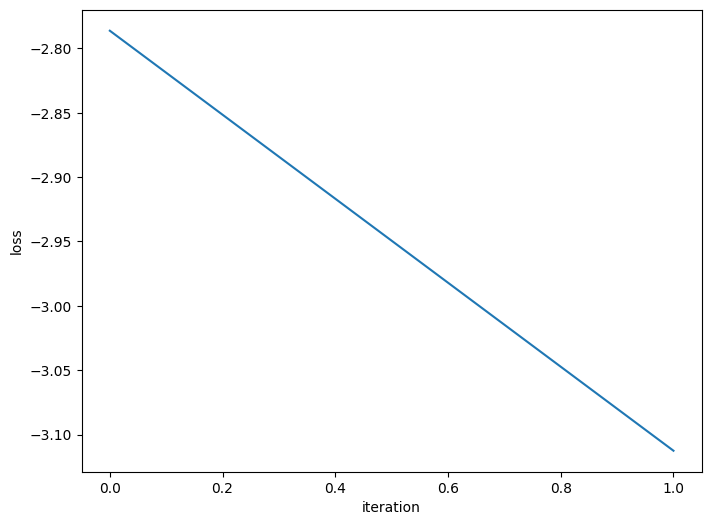

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -611.78973  validloss -655.52304±0.00000  bestvalidloss -655.52304  last_update 0
train: iter 1  trainloss -595.89180  validloss -642.04176±0.00000  bestvalidloss -655.52304  last_update 1
train: iter 2  trainloss -622.50757  validloss -651.50831±0.00000  bestvalidloss -655.52304  last_update 2
train: iter 3  trainloss -618.90483  validloss -654.91350±0.00000  bestvalidloss -655.52304  last_update 3
train: iter 4  trainloss -595.62003  validloss -673.27313±0.00000  bestvalidloss -673.27313  last_update 0
train: iter 5  trainloss -628.04404  validloss -664.27609±0.00000  bestvalidloss -673.27313  last_update 1
train: iter 6  trainloss -630.02081  validloss -668.23695±0.00000  bestvalidloss -673.27313  last_update 2
train: iter 7  trainloss -618.90167  validloss -651.40285±0.00000  bestvalidloss -673.27313  last_update 3
train: iter 8  trainloss -618.32727  validloss -664.94914±0.00000  bestvalidloss -673.27313  last_u

train: iter 75  trainloss -601.08281  validloss -658.14768±0.00000  bestvalidloss -673.27313  last_update 71
train: iter 76  trainloss -619.74915  validloss -657.00131±0.00000  bestvalidloss -673.27313  last_update 72
train: iter 77  trainloss -611.15909  validloss -652.26168±0.00000  bestvalidloss -673.27313  last_update 73
train: iter 78  trainloss -604.39743  validloss -653.13422±0.00000  bestvalidloss -673.27313  last_update 74
train: iter 79  trainloss -616.20118  validloss -654.86590±0.00000  bestvalidloss -673.27313  last_update 75
train: iter 80  trainloss -625.76619  validloss -637.96767±0.00000  bestvalidloss -673.27313  last_update 76
train: iter 81  trainloss -590.05271  validloss -641.97524±0.00000  bestvalidloss -673.27313  last_update 77
train: iter 82  trainloss -620.18401  validloss -653.66322±0.00000  bestvalidloss -673.27313  last_update 78
train: iter 83  trainloss -612.91934  validloss -640.71942±0.00000  bestvalidloss -673.27313  last_update 79
train: iter 84  tra

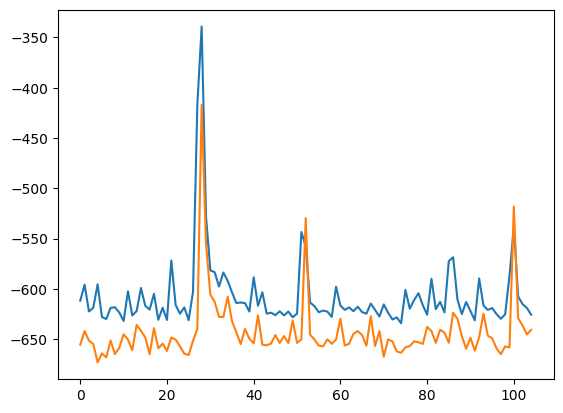

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-31 23:33:40.681333


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24
predict diverge [  7.39298455   4.26825403 -45.19022568 -34.84122812] [-0.29644659  3.95838976 -1.69544622 -2.75066221] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 147

 25

 26

 27

 28

 29
predict diverge [ 15.9310567   23.10282845 -43.40076588 -27.67047854] [ 0.87950846  2.07930805 -1.2115255  -2.03045642] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 96

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45
predict diverge [ 17.27904304  20.09154346 -56.30387612 -34.70131666] [ 0.60592864  2.46929018 -0.9700043  -8.9661562 ] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 112

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.39733  validloss 0.56762±0.00000  bestvalidloss 0.56762  last_update 0
train: iter 1  trainloss 0.35034  validloss 0.43293±0.00000  bestvalidloss 0.43293  last_update 0
train: iter 2  trainloss 0.33569  validloss 0.42223±0.00000  bestvalidloss 0.42223  last_update 0
train: iter 3  trainloss 0.33697  validloss 0.39737±0.00000  bestvalidloss 0.39737  last_update 0
train: iter 4  trainloss 0.32180  validloss 0.40591±0.00000  bestvalidloss 0.39737  last_update 1
train: iter 5  trainloss 0.32561  validloss 0.39986±0.00000  bestvalidloss 0.39737  last_update 2
train: iter 6  trainloss 0.32544  validloss 0.41820±0.00000  bestvalidloss 0.39737  last_update 3
train: iter 7  trainloss 0.31892  validloss 0.41204±0.00000  bestvalidloss 0.39737  last_update 4
train: iter 8  trainloss 0.31844  validloss 0.40435±0.00000  bestvalidloss 0.39737  last_update 5
train: iter 9  trainloss 0.31287  validloss 0.39641±0.00000  bestvalidloss 0.39641  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.27480  validloss 0.37910±0.00000  bestvalidloss 0.37586  last_update 12
train: iter 84  trainloss 0.27169  validloss 0.37445±0.00000  bestvalidloss 0.37445  last_update 0
train: iter 85  trainloss 0.27391  validloss 0.37760±0.00000  bestvalidloss 0.37445  last_update 1
train: iter 86  trainloss 0.27236  validloss 0.38306±0.00000  bestvalidloss 0.37445  last_update 2
train: iter 87  trainloss 0.27194  validloss 0.38320±0.00000  bestvalidloss 0.37445  last_update 3
train: iter 88  trainloss 0.27039  validloss 0.38609±0.00000  bestvalidloss 0.37445  last_update 4
train: iter 89  trainloss 0.27289  validloss 0.37813±0.00000  bestvalidloss 0.37445  last_update 5
train: iter 90  trainloss 0.27571  validloss 0.39283±0.00000  bestvalidloss 0.37445  last_update 6
train: iter 91  trainloss 0.26909  validloss 0.37707±0.00000  bestvalidloss 0.37445  last_update 7
train: iter 92  trainloss 0.27137  validloss 0.37965±0.00000  bestvalidloss 0.37445  last_update 8
train: it

train: iter 165  trainloss 0.25893  validloss 0.37586±0.00000  bestvalidloss 0.37007  last_update 10
train: iter 166  trainloss 0.26156  validloss 0.38543±0.00000  bestvalidloss 0.37007  last_update 11
train: iter 167  trainloss 0.26182  validloss 0.37364±0.00000  bestvalidloss 0.37007  last_update 12
train: iter 168  trainloss 0.26078  validloss 0.37485±0.00000  bestvalidloss 0.37007  last_update 13
train: iter 169  trainloss 0.26014  validloss 0.38373±0.00000  bestvalidloss 0.37007  last_update 14
train: iter 170  trainloss 0.25882  validloss 0.36980±0.00000  bestvalidloss 0.36980  last_update 0
train: iter 171  trainloss 0.25999  validloss 0.38149±0.00000  bestvalidloss 0.36980  last_update 1
train: iter 172  trainloss 0.25921  validloss 0.37230±0.00000  bestvalidloss 0.36980  last_update 2
train: iter 173  trainloss 0.26444  validloss 0.37213±0.00000  bestvalidloss 0.36980  last_update 3
train: iter 174  trainloss 0.26078  validloss 0.37555±0.00000  bestvalidloss 0.36980  last_upda

train: iter 247  trainloss 0.24859  validloss 0.37607±0.00000  bestvalidloss 0.36490  last_update 64
train: iter 248  trainloss 0.24898  validloss 0.37290±0.00000  bestvalidloss 0.36490  last_update 65
train: iter 249  trainloss 0.25028  validloss 0.37358±0.00000  bestvalidloss 0.36490  last_update 66
train: iter 250  trainloss 0.25127  validloss 0.37875±0.00000  bestvalidloss 0.36490  last_update 67
train: iter 251  trainloss 0.25003  validloss 0.37308±0.00000  bestvalidloss 0.36490  last_update 68
train: iter 252  trainloss 0.25014  validloss 0.37356±0.00000  bestvalidloss 0.36490  last_update 69
train: iter 253  trainloss 0.24781  validloss 0.37657±0.00000  bestvalidloss 0.36490  last_update 70
train: iter 254  trainloss 0.25009  validloss 0.36576±0.00000  bestvalidloss 0.36490  last_update 71
train: iter 255  trainloss 0.25064  validloss 0.38228±0.00000  bestvalidloss 0.36490  last_update 72
train: iter 256  trainloss 0.24756  validloss 0.37400±0.00000  bestvalidloss 0.36490  last_

train: iter 329  trainloss 0.24240  validloss 0.37453±0.00000  bestvalidloss 0.36454  last_update 62
train: iter 330  trainloss 0.24181  validloss 0.37267±0.00000  bestvalidloss 0.36454  last_update 63
train: iter 331  trainloss 0.24216  validloss 0.37954±0.00000  bestvalidloss 0.36454  last_update 64
train: iter 332  trainloss 0.24148  validloss 0.37423±0.00000  bestvalidloss 0.36454  last_update 65
train: iter 333  trainloss 0.24163  validloss 0.37561±0.00000  bestvalidloss 0.36454  last_update 66
train: iter 334  trainloss 0.24077  validloss 0.37516±0.00000  bestvalidloss 0.36454  last_update 67
train: iter 335  trainloss 0.24050  validloss 0.37451±0.00000  bestvalidloss 0.36454  last_update 68
train: iter 336  trainloss 0.24312  validloss 0.36962±0.00000  bestvalidloss 0.36454  last_update 69
train: iter 337  trainloss 0.24222  validloss 0.37448±0.00000  bestvalidloss 0.36454  last_update 70
train: iter 338  trainloss 0.24062  validloss 0.37359±0.00000  bestvalidloss 0.36454  last_

train_loss:  -4.303605422985554
valid_loss:  -9.033297644627094
weight_alpha 1.0 h_min_tilde -11.640876 ell_tilde -5.249543867313862 kappa_tilde 0.0003955526631745867
train_loss:  -2.9182145061731335
valid_loss:  -3.1705668731689456
weight_alpha 0.1 h_min_tilde -11.640876 ell_tilde -2.968684979572296 kappa_tilde 0.0003395749042409788


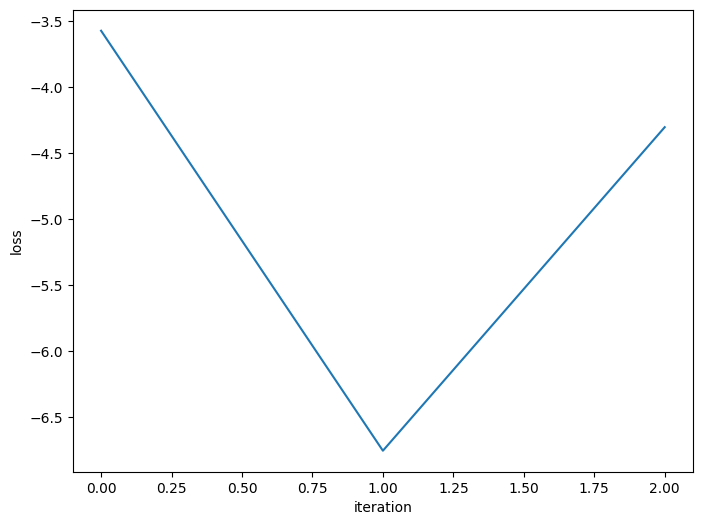

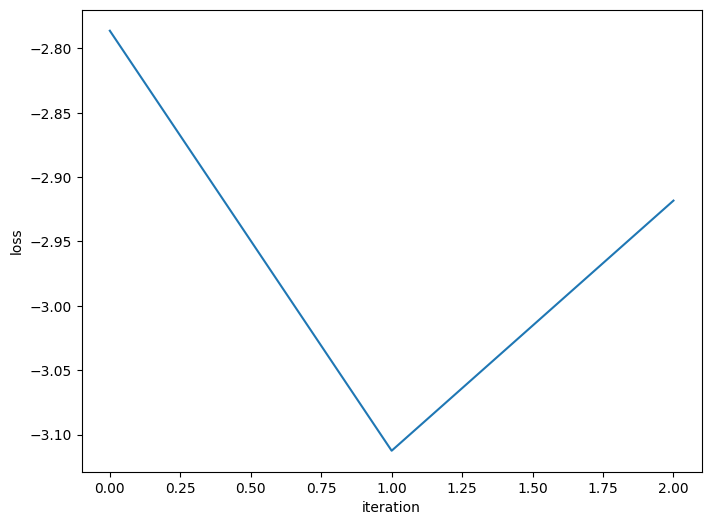

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -580.75993  validloss -632.04904±0.00000  bestvalidloss -632.04904  last_update 0
train: iter 1  trainloss -564.68709  validloss -609.74944±0.00000  bestvalidloss -632.04904  last_update 1
train: iter 2  trainloss -575.93874  validloss -607.30201±0.00000  bestvalidloss -632.04904  last_update 2
train: iter 3  trainloss -587.22884  validloss -636.57451±0.00000  bestvalidloss -636.57451  last_update 0
train: iter 4  trainloss -486.93723  validloss -614.79156±0.00000  bestvalidloss -636.57451  last_update 1
train: iter 5  trainloss -538.63186  validloss -581.23185±0.00000  bestvalidloss -636.57451  last_update 2
train: iter 6  trainloss -512.51218  validloss -627.19132±0.00000  bestvalidloss -636.57451  last_update 3
train: iter 7  trainloss -457.86161  validloss -612.06398±0.00000  bestvalidloss -636.57451  last_update 4
train: iter 8  trainloss -542.96271  validloss -613.61768±0.00000  bestvalidloss -636.57451  last_u

train: iter 76  trainloss -556.03473  validloss -553.01124±0.00000  bestvalidloss -659.85009  last_update 60
train: iter 77  trainloss -577.95902  validloss -620.58611±0.00000  bestvalidloss -659.85009  last_update 61
train: iter 78  trainloss -583.85771  validloss -618.06486±0.00000  bestvalidloss -659.85009  last_update 62
train: iter 79  trainloss -583.09200  validloss -639.09315±0.00000  bestvalidloss -659.85009  last_update 63
train: iter 80  trainloss -575.59853  validloss -574.35528±0.00000  bestvalidloss -659.85009  last_update 64
train: iter 81  trainloss -593.21218  validloss -643.49467±0.00000  bestvalidloss -659.85009  last_update 65
train: iter 82  trainloss -582.39118  validloss -631.84039±0.00000  bestvalidloss -659.85009  last_update 66
train: iter 83  trainloss -577.75790  validloss -598.51904±0.00000  bestvalidloss -659.85009  last_update 67
train: iter 84  trainloss -587.18230  validloss -639.70687±0.00000  bestvalidloss -659.85009  last_update 68
train: iter 85  tra

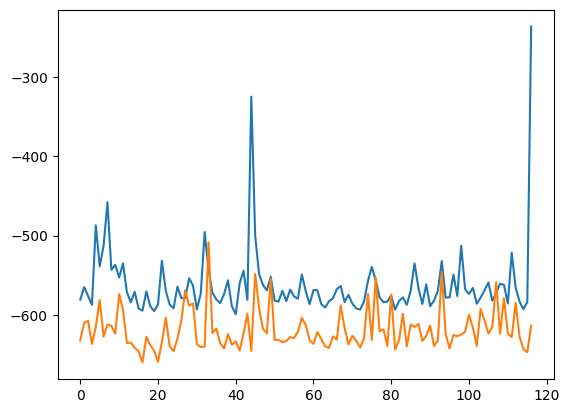

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-01 00:00:59.858294


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [-42.24062435   5.23992469  16.71830093  37.36776453] [-0.50759506  2.90705758  0.83905895 17.81981758] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 104

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32
predict diverge [-26.87902256  12.42437612  33.54843298  39.20113168] [-0.60612667  0.22559188  1.05946936 12.19040948] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 141

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47
predict diverge [-10.04144727  -3.15402292  25.31938906  33.97248171] [-0.1329041  -5.75132454  0.7648755  14.11995205] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 69

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 3.67915  validloss 7.50508±0.00000  bestvalidloss 7.50508  last_update 0
train: iter 1  trainloss 1.14434  validloss 1.58292±0.00000  bestvalidloss 1.58292  last_update 0
train: iter 2  trainloss 0.89820  validloss 1.12345±0.00000  bestvalidloss 1.12345  last_update 0
train: iter 3  trainloss 0.80100  validloss 0.96647±0.00000  bestvalidloss 0.96647  last_update 0
train: iter 4  trainloss 0.74204  validloss 0.88232±0.00000  bestvalidloss 0.88232  last_update 0
train: iter 5  trainloss 0.69490  validloss 0.84707±0.00000  bestvalidloss 0.84707  last_update 0
train: iter 6  trainloss 0.65274  validloss 0.81797±0.00000  bestvalidloss 0.81797  last_update 0
train: iter 7  trainloss 0.62278  validloss 0.80755±0.00000  bestvalidloss 0.80755  last_update 0
train: iter 8  trainloss 0.59714  validloss 0.76877±0.00000  bestvalidloss 0.76877  last_update 0
train: iter 9  trainloss 0.57277  validloss 0.75824±0.00000  bestvalidloss 0.75824  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.33854  validloss 0.52246±0.00000  bestvalidloss 0.50271  last_update 4
train: iter 85  trainloss 0.34060  validloss 0.51551±0.00000  bestvalidloss 0.50271  last_update 5
train: iter 86  trainloss 0.33592  validloss 0.50852±0.00000  bestvalidloss 0.50271  last_update 6
train: iter 87  trainloss 0.33904  validloss 0.52135±0.00000  bestvalidloss 0.50271  last_update 7
train: iter 88  trainloss 0.33838  validloss 0.51056±0.00000  bestvalidloss 0.50271  last_update 8
train: iter 89  trainloss 0.33670  validloss 0.52918±0.00000  bestvalidloss 0.50271  last_update 9
train: iter 90  trainloss 0.33496  validloss 0.51528±0.00000  bestvalidloss 0.50271  last_update 10
train: iter 91  trainloss 0.33624  validloss 0.51415±0.00000  bestvalidloss 0.50271  last_update 11
train: iter 92  trainloss 0.33382  validloss 0.51423±0.00000  bestvalidloss 0.50271  last_update 12
train: iter 93  trainloss 0.33346  validloss 0.52000±0.00000  bestvalidloss 0.50271  last_update 13
train:

train: iter 166  trainloss 0.30145  validloss 0.48140±0.00000  bestvalidloss 0.47737  last_update 10
train: iter 167  trainloss 0.30019  validloss 0.47903±0.00000  bestvalidloss 0.47737  last_update 11
train: iter 168  trainloss 0.30273  validloss 0.48043±0.00000  bestvalidloss 0.47737  last_update 12
train: iter 169  trainloss 0.30050  validloss 0.48948±0.00000  bestvalidloss 0.47737  last_update 13
train: iter 170  trainloss 0.29983  validloss 0.47993±0.00000  bestvalidloss 0.47737  last_update 14
train: iter 171  trainloss 0.30117  validloss 0.48799±0.00000  bestvalidloss 0.47737  last_update 15
train: iter 172  trainloss 0.29786  validloss 0.48737±0.00000  bestvalidloss 0.47737  last_update 16
train: iter 173  trainloss 0.29934  validloss 0.48171±0.00000  bestvalidloss 0.47737  last_update 17
train: iter 174  trainloss 0.29870  validloss 0.48019±0.00000  bestvalidloss 0.47737  last_update 18
train: iter 175  trainloss 0.29887  validloss 0.48368±0.00000  bestvalidloss 0.47737  last_

train: iter 248  trainloss 0.27990  validloss 0.48372±0.00000  bestvalidloss 0.47604  last_update 61
train: iter 249  trainloss 0.28031  validloss 0.49742±0.00000  bestvalidloss 0.47604  last_update 62
train: iter 250  trainloss 0.27868  validloss 0.49446±0.00000  bestvalidloss 0.47604  last_update 63
train: iter 251  trainloss 0.28061  validloss 0.48977±0.00000  bestvalidloss 0.47604  last_update 64
train: iter 252  trainloss 0.27909  validloss 0.48423±0.00000  bestvalidloss 0.47604  last_update 65
train: iter 253  trainloss 0.28028  validloss 0.48358±0.00000  bestvalidloss 0.47604  last_update 66
train: iter 254  trainloss 0.28156  validloss 0.51090±0.00000  bestvalidloss 0.47604  last_update 67
train: iter 255  trainloss 0.27991  validloss 0.50368±0.00000  bestvalidloss 0.47604  last_update 68
train: iter 256  trainloss 0.28062  validloss 0.48702±0.00000  bestvalidloss 0.47604  last_update 69
train: iter 257  trainloss 0.27921  validloss 0.49121±0.00000  bestvalidloss 0.47604  last_

train_loss:  -3.068175437989831
valid_loss:  -6.459220516586304
weight_alpha 1.0 h_min_tilde -9.986818 ell_tilde -3.7463844537091258 kappa_tilde 0.0004003064683347264
train_loss:  -1.8119054189562795
valid_loss:  -1.959102630281448
weight_alpha 0.1 h_min_tilde -9.986818 ell_tilde -1.8413448612213132 kappa_tilde 0.00035038203746679935


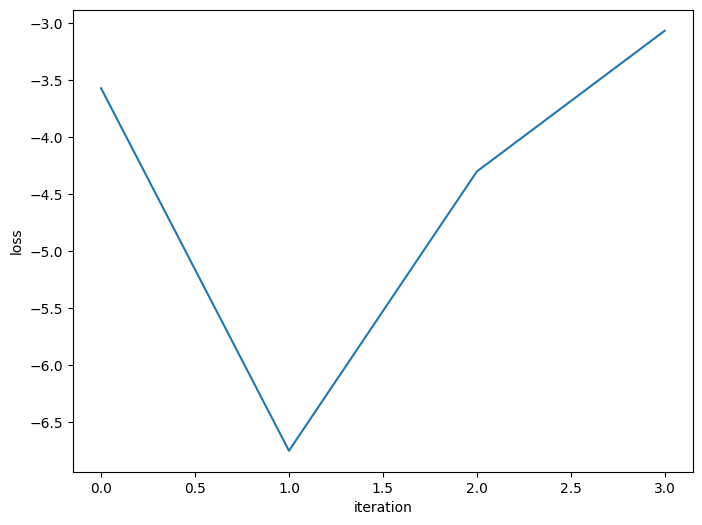

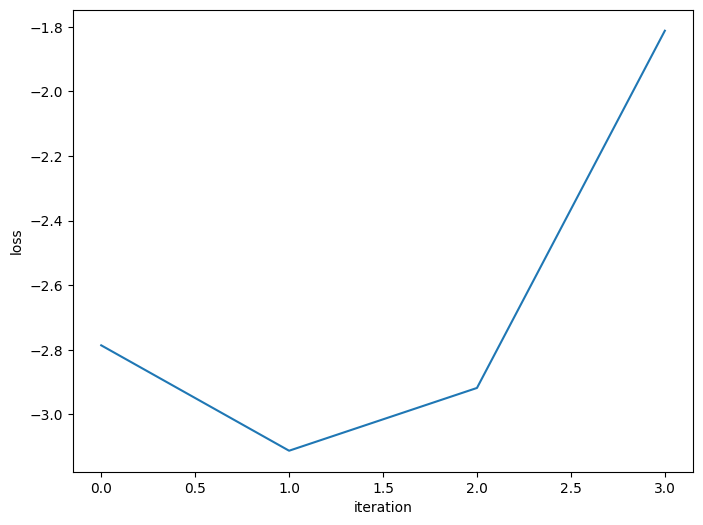

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -527.86762  validloss -397.43511±0.00000  bestvalidloss -397.43511  last_update 0
train: iter 1  trainloss -778.46315  validloss -794.36384±0.00000  bestvalidloss -794.36384  last_update 0
train: iter 2  trainloss -809.34406  validloss -857.84649±0.00000  bestvalidloss -857.84649  last_update 0
train: iter 3  trainloss -818.38883  validloss -862.50040±0.00000  bestvalidloss -862.50040  last_update 0
train: iter 4  trainloss -807.51306  validloss -875.52517±0.00000  bestvalidloss -875.52517  last_update 0
train: iter 5  trainloss -819.96990  validloss -893.39026±0.00000  bestvalidloss -893.39026  last_update 0
train: iter 6  trainloss -820.05278  validloss -867.25019±0.00000  bestvalidloss -893.39026  last_update 1
train: iter 7  trainloss -845.17997  validloss -859.21761±0.00000  bestvalidloss -893.39026  last_update 2
train: iter 8  trainloss -824.13859  validloss -895.23576±0.00000  bestvalidloss -895.23576  last_u

train: iter 76  trainloss -811.00916  validloss -847.51615±0.00000  bestvalidloss -909.35068  last_update 48
train: iter 77  trainloss -822.15747  validloss -861.93062±0.00000  bestvalidloss -909.35068  last_update 49
train: iter 78  trainloss -834.35017  validloss -879.35746±0.00000  bestvalidloss -909.35068  last_update 50
train: iter 79  trainloss -845.15194  validloss -888.06776±0.00000  bestvalidloss -909.35068  last_update 51
train: iter 80  trainloss -818.10842  validloss -790.16089±0.00000  bestvalidloss -909.35068  last_update 52
train: iter 81  trainloss -828.97801  validloss -853.50543±0.00000  bestvalidloss -909.35068  last_update 53
train: iter 82  trainloss -842.56825  validloss -896.27696±0.00000  bestvalidloss -909.35068  last_update 54
train: iter 83  trainloss -812.68785  validloss -849.59263±0.00000  bestvalidloss -909.35068  last_update 55
train: iter 84  trainloss -822.98332  validloss -822.47922±0.00000  bestvalidloss -909.35068  last_update 56
train: iter 85  tra

train: iter 151  trainloss -797.95825  validloss -822.64454±0.00000  bestvalidloss -918.32379  last_update 31
train: iter 152  trainloss -803.03568  validloss -873.78826±0.00000  bestvalidloss -918.32379  last_update 32
train: iter 153  trainloss -808.33078  validloss -843.35382±0.00000  bestvalidloss -918.32379  last_update 33
train: iter 154  trainloss -825.96045  validloss -866.71184±0.00000  bestvalidloss -918.32379  last_update 34
train: iter 155  trainloss -836.02656  validloss -883.42071±0.00000  bestvalidloss -918.32379  last_update 35
train: iter 156  trainloss -767.87001  validloss -728.54918±0.00000  bestvalidloss -918.32379  last_update 36
train: iter 157  trainloss -833.41909  validloss -864.76320±0.00000  bestvalidloss -918.32379  last_update 37
train: iter 158  trainloss -847.02214  validloss -893.41485±0.00000  bestvalidloss -918.32379  last_update 38
train: iter 159  trainloss -842.01670  validloss -916.01278±0.00000  bestvalidloss -918.32379  last_update 39
train: ite

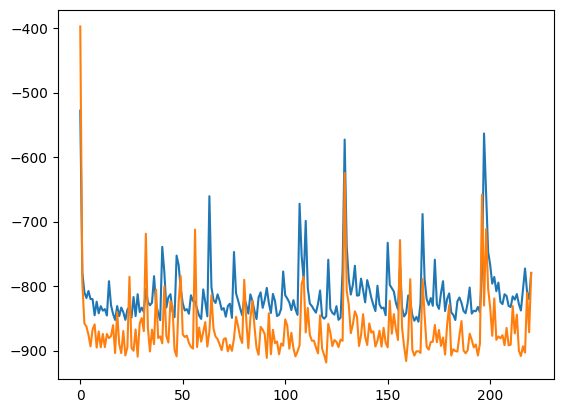

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-01 00:27:44.325019


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22
predict diverge [  3.30996081 -35.40863087 -24.8056319  -33.09933698] [  0.63350847 -39.95462783  -1.33700023  -5.15569717] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 53

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36
predict diverge [  1.74989789  20.40804086 -16.35530354 -37.62491058] [ 0.89951819  2.71557196 -1.50757974 -6.98979365] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 44

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47
predict diverge [  0.91711057  30.50502389 -21.66169744 -28.89506205] [-0.13760865 36.22668943 -0.09398591  1.67089692] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 72

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.50810  validloss 0.82036±0.00000  bestvalidloss 0.82036  last_update 0
train: iter 1  trainloss 0.39738  validloss 0.45658±0.00000  bestvalidloss 0.45658  last_update 0
train: iter 2  trainloss 0.36921  validloss 0.41881±0.00000  bestvalidloss 0.41881  last_update 0
train: iter 3  trainloss 0.35122  validloss 0.40803±0.00000  bestvalidloss 0.40803  last_update 0
train: iter 4  trainloss 0.34202  validloss 0.39847±0.00000  bestvalidloss 0.39847  last_update 0
train: iter 5  trainloss 0.33268  validloss 0.39114±0.00000  bestvalidloss 0.39114  last_update 0
train: iter 6  trainloss 0.32797  validloss 0.39391±0.00000  bestvalidloss 0.39114  last_update 1
train: iter 7  trainloss 0.32412  validloss 0.39676±0.00000  bestvalidloss 0.39114  last_update 2
train: iter 8  trainloss 0.32097  validloss 0.38183±0.00000  bestvalidloss 0.38183  last_update 0
train: iter 9  trainloss 0.31521  validloss 0.38383±0.00000  bestvalidloss 0.38183  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.24408  validloss 0.36341±0.00000  bestvalidloss 0.35097  last_update 1
train: iter 84  trainloss 0.24465  validloss 0.36096±0.00000  bestvalidloss 0.35097  last_update 2
train: iter 85  trainloss 0.24461  validloss 0.36793±0.00000  bestvalidloss 0.35097  last_update 3
train: iter 86  trainloss 0.24389  validloss 0.35580±0.00000  bestvalidloss 0.35097  last_update 4
train: iter 87  trainloss 0.24311  validloss 0.35648±0.00000  bestvalidloss 0.35097  last_update 5
train: iter 88  trainloss 0.24024  validloss 0.34836±0.00000  bestvalidloss 0.34836  last_update 0
train: iter 89  trainloss 0.24172  validloss 0.35596±0.00000  bestvalidloss 0.34836  last_update 1
train: iter 90  trainloss 0.23983  validloss 0.36609±0.00000  bestvalidloss 0.34836  last_update 2
train: iter 91  trainloss 0.24136  validloss 0.35286±0.00000  bestvalidloss 0.34836  last_update 3
train: iter 92  trainloss 0.23860  validloss 0.35496±0.00000  bestvalidloss 0.34836  last_update 4
train: ite

train: iter 165  trainloss 0.22067  validloss 0.34977±0.00000  bestvalidloss 0.33897  last_update 24
train: iter 166  trainloss 0.22131  validloss 0.34147±0.00000  bestvalidloss 0.33897  last_update 25
train: iter 167  trainloss 0.21804  validloss 0.35438±0.00000  bestvalidloss 0.33897  last_update 26
train: iter 168  trainloss 0.22074  validloss 0.34154±0.00000  bestvalidloss 0.33897  last_update 27
train: iter 169  trainloss 0.21966  validloss 0.34955±0.00000  bestvalidloss 0.33897  last_update 28
train: iter 170  trainloss 0.22130  validloss 0.35361±0.00000  bestvalidloss 0.33897  last_update 29
train: iter 171  trainloss 0.22070  validloss 0.34211±0.00000  bestvalidloss 0.33897  last_update 30
train: iter 172  trainloss 0.21997  validloss 0.34828±0.00000  bestvalidloss 0.33897  last_update 31
train: iter 173  trainloss 0.21865  validloss 0.34451±0.00000  bestvalidloss 0.33897  last_update 32
train: iter 174  trainloss 0.21982  validloss 0.34724±0.00000  bestvalidloss 0.33897  last_

train_loss:  -4.783048432263731
valid_loss:  -9.598482804441455
weight_alpha 1.0 h_min_tilde -11.648462 ell_tilde -5.746135306699276 kappa_tilde 0.0004116123218426571
train_loss:  -2.9375033251047133
valid_loss:  -3.306767721748352
weight_alpha 0.1 h_min_tilde -11.648462 ell_tilde -3.0113562044334414 kappa_tilde 0.00034026389802492617


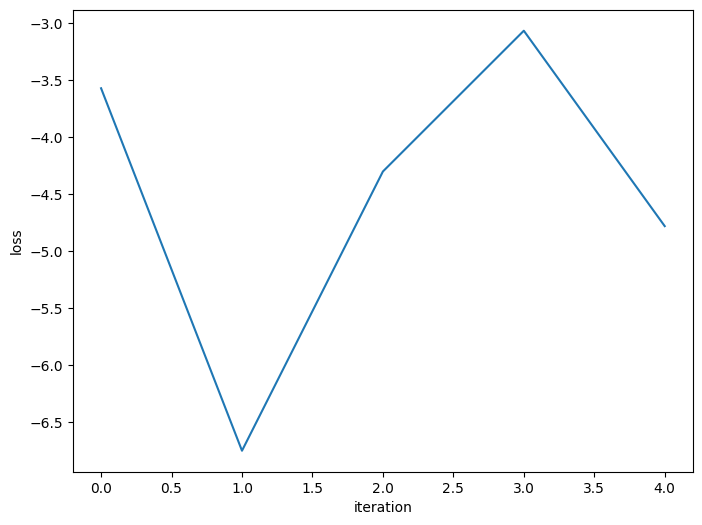

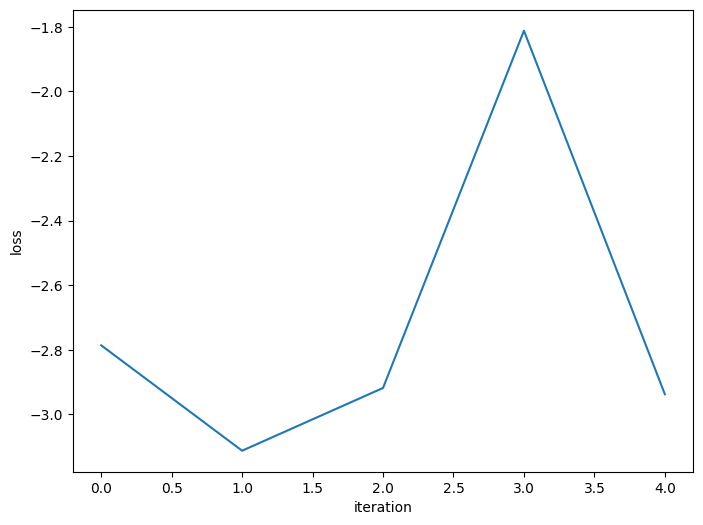

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -577.37212  validloss -663.45525±0.00000  bestvalidloss -663.45525  last_update 0
train: iter 1  trainloss -596.73497  validloss -671.49537±0.00000  bestvalidloss -671.49537  last_update 0
train: iter 2  trainloss -599.92920  validloss -665.27609±0.00000  bestvalidloss -671.49537  last_update 1
train: iter 3  trainloss -594.04981  validloss -677.90823±0.00000  bestvalidloss -677.90823  last_update 0
train: iter 4  trainloss -602.94422  validloss -649.08888±0.00000  bestvalidloss -677.90823  last_update 1
train: iter 5  trainloss -598.84241  validloss -669.67278±0.00000  bestvalidloss -677.90823  last_update 2
train: iter 6  trainloss -610.92358  validloss -687.11577±0.00000  bestvalidloss -687.11577  last_update 0
train: iter 7  trainloss -517.98951  validloss -645.11743±0.00000  bestvalidloss -687.11577  last_update 1
train: iter 8  trainloss -590.74936  validloss -645.72433±0.00000  bestvalidloss -687.11577  last_u

train: iter 76  trainloss -570.18474  validloss -656.23349±0.00000  bestvalidloss -692.71938  last_update 7
train: iter 77  trainloss -595.98879  validloss -650.44573±0.00000  bestvalidloss -692.71938  last_update 8
train: iter 78  trainloss -574.43664  validloss -670.33386±0.00000  bestvalidloss -692.71938  last_update 9
train: iter 79  trainloss -596.07598  validloss -655.24506±0.00000  bestvalidloss -692.71938  last_update 10
train: iter 80  trainloss -606.32102  validloss -664.87115±0.00000  bestvalidloss -692.71938  last_update 11
train: iter 81  trainloss -603.50599  validloss -677.53161±0.00000  bestvalidloss -692.71938  last_update 12
train: iter 82  trainloss -545.97365  validloss -664.52701±0.00000  bestvalidloss -692.71938  last_update 13
train: iter 83  trainloss -564.88197  validloss -584.18459±0.00000  bestvalidloss -692.71938  last_update 14
train: iter 84  trainloss -586.45190  validloss -650.95118±0.00000  bestvalidloss -692.71938  last_update 15
train: iter 85  trainl

train: iter 151  trainloss -600.18650  validloss -660.70230±0.00000  bestvalidloss -692.71938  last_update 82
train: iter 152  trainloss -584.14651  validloss -650.31559±0.00000  bestvalidloss -692.71938  last_update 83
train: iter 153  trainloss -574.39424  validloss -589.31886±0.00000  bestvalidloss -692.71938  last_update 84
train: iter 154  trainloss -608.97147  validloss -678.24930±0.00000  bestvalidloss -692.71938  last_update 85
train: iter 155  trainloss -588.18070  validloss -645.09388±0.00000  bestvalidloss -692.71938  last_update 86
train: iter 156  trainloss -603.91803  validloss -669.83661±0.00000  bestvalidloss -692.71938  last_update 87
train: iter 157  trainloss -591.77554  validloss -658.16673±0.00000  bestvalidloss -692.71938  last_update 88
train: iter 158  trainloss -604.22007  validloss -667.88799±0.00000  bestvalidloss -692.71938  last_update 89
train: iter 159  trainloss -598.75230  validloss -668.25542±0.00000  bestvalidloss -692.71938  last_update 90
train: ite

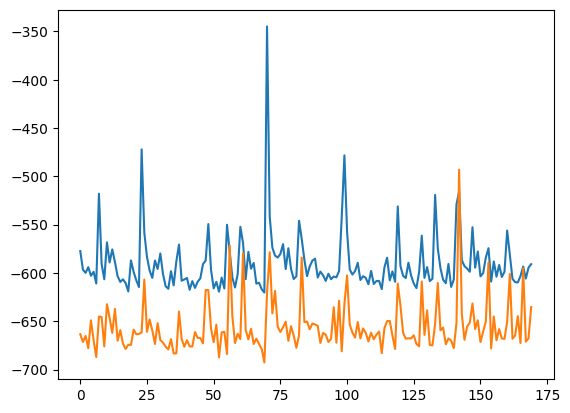

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-01 00:54:34.999573


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.29438  validloss 0.47302±0.00000  bestvalidloss 0.47302  last_update 0
train: iter 1  trainloss 0.27951  validloss 0.41539±0.00000  bestvalidloss 0.41539  last_update 0
train: iter 2  trainloss 0.27201  validloss 0.41325±0.00000  bestvalidloss 0.41325  last_update 0
train: iter 3  trainloss 0.26589  validloss 0.39493±0.00000  bestvalidloss 0.39493  last_update 0
train: iter 4  trainloss 0.26435  validloss 0.39935±0.00000  bestvalidloss 0.39493  last_update 1
train: iter 5  trainloss 0.25887  validloss 0.40765±0.00000  bestvalidloss 0.39493  last_update 2
train: iter 6  trainloss 0.25590  validloss 0.39657±0.00000  bestvalidloss 0.39493  last_update 3
train: iter 7  trainloss 0.25367  validloss 0.38690±0.00000  bestvalidloss 0.38690  last_update 0
train: iter 8  trainloss 0.25081  validloss 0.38807±0.00000  bestvalidloss 0.38690  last_update 1
train: iter 9  trainloss 0.25023  validloss 0.39316±0.00000  bestvalidloss 0.38690  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.21805  validloss 0.38535±0.00000  bestvalidloss 0.37165  last_update 51
train: iter 84  trainloss 0.21737  validloss 0.39279±0.00000  bestvalidloss 0.37165  last_update 52
train: iter 85  trainloss 0.21937  validloss 0.38088±0.00000  bestvalidloss 0.37165  last_update 53
train: iter 86  trainloss 0.22048  validloss 0.38693±0.00000  bestvalidloss 0.37165  last_update 54
train: iter 87  trainloss 0.21929  validloss 0.41567±0.00000  bestvalidloss 0.37165  last_update 55
train: iter 88  trainloss 0.21648  validloss 0.39997±0.00000  bestvalidloss 0.37165  last_update 56
train: iter 89  trainloss 0.21592  validloss 0.40461±0.00000  bestvalidloss 0.37165  last_update 57
train: iter 90  trainloss 0.21597  validloss 0.39312±0.00000  bestvalidloss 0.37165  last_update 58
train: iter 91  trainloss 0.21946  validloss 0.39659±0.00000  bestvalidloss 0.37165  last_update 59
train: iter 92  trainloss 0.21618  validloss 0.39765±0.00000  bestvalidloss 0.37165  last_update 60


([0.2943797945044935,
  0.2795084203593433,
  0.2720117757562548,
  0.2658930944278836,
  0.26435407386161386,
  0.2588655972853303,
  0.25589657765813173,
  0.2536706870421767,
  0.2508072532247752,
  0.2502337275072932,
  0.24939667354337872,
  0.24868223313242196,
  0.24210198135115207,
  0.24423446743749083,
  0.24445084072649478,
  0.24516185014508665,
  0.24299265746958554,
  0.2407681645359844,
  0.2388702872674912,
  0.24426982109434903,
  0.23934905002824963,
  0.2373598909471184,
  0.23668538788333535,
  0.23482973189093173,
  0.23518992434255778,
  0.23430314012803138,
  0.23424914302304387,
  0.23566300570964813,
  0.2332183422986418,
  0.23059245282784105,
  0.23035334795713425,
  0.235029188496992,
  0.2303543033078313,
  0.23284587995149195,
  0.23045566608197987,
  0.2283843129873276,
  0.23076290218159556,
  0.22840113420970737,
  0.23007733495905996,
  0.22980016418732702,
  0.22787083303555847,
  0.226737450202927,
  0.22639868981204928,
  0.2262668010313064,
  0.225

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.686503293201328
valid_loss:  -12.017101362800597
weight_alpha 1.0 h_min_tilde -11.549156 ell_tilde -6.952622907121181 kappa_tilde 0.0004664281954093433
train_loss:  -3.578923264980316
valid_loss:  -3.902858517456054
weight_alpha 0.1 h_min_tilde -11.549156 ell_tilde -3.6437103154754635 kappa_tilde 0.00035566146679447564


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 21.77897  validloss 24.13365±0.00000  bestvalidloss 24.13365  last_update 0
train: iter 1  trainloss 17.57590  validloss 19.70408±0.00000  bestvalidloss 19.70408  last_update 0
train: iter 2  trainloss 14.26115  validloss 15.79747±0.00000  bestvalidloss 15.79747  last_update 0
train: iter 3  trainloss 11.64225  validloss 12.94907±0.00000  bestvalidloss 12.94907  last_update 0
train: iter 4  trainloss 9.78011  validloss 10.90750±0.00000  bestvalidloss 10.90750  last_update 0
train: iter 5  trainloss 8.02530  validloss 8.97094±0.00000  bestvalidloss 8.97094  last_update 0
train: iter 6  trainloss 6.73143  validloss 7.22800±0.00000  bestvalidloss 7.22800  last_update 0
train: iter 7  trainloss 5.68772  validloss 6.24025±0.00000  bestvalidloss 6.24025  last_update 0
train: iter 8  trainloss 4.64242  validloss 5.15242±0.00000  bestvalidloss 5.15242  last_update 0
train: iter 9  trainloss 3.92687  validloss 4.43437±0.00000  bestvalidloss 4.43437  last_update 0
train:

train: iter 83  trainloss -0.57330  validloss -0.53734±0.00000  bestvalidloss -0.57465  last_update 2
train: iter 84  trainloss -0.58840  validloss -0.54404±0.00000  bestvalidloss -0.57465  last_update 3
train: iter 85  trainloss -0.57752  validloss -0.63098±0.00000  bestvalidloss -0.63098  last_update 0
train: iter 86  trainloss -0.61634  validloss -0.60763±0.00000  bestvalidloss -0.63098  last_update 1
train: iter 87  trainloss -0.62636  validloss -0.58068±0.00000  bestvalidloss -0.63098  last_update 2
train: iter 88  trainloss -0.60939  validloss -0.59987±0.00000  bestvalidloss -0.63098  last_update 3
train: iter 89  trainloss -0.68954  validloss -0.67143±0.00000  bestvalidloss -0.67143  last_update 0
train: iter 90  trainloss -0.67321  validloss -0.63906±0.00000  bestvalidloss -0.67143  last_update 1
train: iter 91  trainloss -0.66027  validloss -0.70380±0.00000  bestvalidloss -0.70380  last_update 0
train: iter 92  trainloss -0.67508  validloss -0.74772±0.00000  bestvalidloss -0.7

train: iter 167  trainloss -0.83464  validloss -0.53601±0.00000  bestvalidloss -0.90320  last_update 38
train: iter 168  trainloss -0.77736  validloss -0.71814±0.00000  bestvalidloss -0.90320  last_update 39
train: iter 169  trainloss -0.84369  validloss -0.68381±0.00000  bestvalidloss -0.90320  last_update 40
train: iter 170  trainloss -0.79405  validloss -0.73059±0.00000  bestvalidloss -0.90320  last_update 41
train: iter 171  trainloss -0.82282  validloss -0.79436±0.00000  bestvalidloss -0.90320  last_update 42
train: iter 172  trainloss -0.75535  validloss -0.71679±0.00000  bestvalidloss -0.90320  last_update 43
train: iter 173  trainloss -0.85100  validloss -0.85113±0.00000  bestvalidloss -0.90320  last_update 44
train: iter 174  trainloss -0.79847  validloss -0.79783±0.00000  bestvalidloss -0.90320  last_update 45
train: iter 175  trainloss -0.79501  validloss -0.62450±0.00000  bestvalidloss -0.90320  last_update 46
train: iter 176  trainloss -0.83946  validloss -0.72376±0.00000 

train: iter 247  trainloss -0.86201  validloss -0.79631±0.00000  bestvalidloss -0.96532  last_update 44
train: iter 248  trainloss -0.80913  validloss -0.66345±0.00000  bestvalidloss -0.96532  last_update 45
train: iter 249  trainloss -0.81732  validloss -0.91434±0.00000  bestvalidloss -0.96532  last_update 46
train: iter 250  trainloss -0.80480  validloss -0.79171±0.00000  bestvalidloss -0.96532  last_update 47
train: iter 251  trainloss -0.79555  validloss -0.70399±0.00000  bestvalidloss -0.96532  last_update 48
train: iter 252  trainloss -0.83945  validloss -0.66548±0.00000  bestvalidloss -0.96532  last_update 49
train: iter 253  trainloss -0.77501  validloss -0.80678±0.00000  bestvalidloss -0.96532  last_update 50
train: iter 254  trainloss -0.83174  validloss -0.75395±0.00000  bestvalidloss -0.96532  last_update 51
train: iter 255  trainloss -0.85922  validloss -0.87175±0.00000  bestvalidloss -0.96532  last_update 52
train: iter 256  trainloss -0.83463  validloss -0.70306±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-2.1224, -0.1731, -5.7207, -1.5650], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 6.23993  validloss 9.45163±0.00000  bestvalidloss 9.45163  last_update 0
train: iter 1  trainloss 5.22562  validloss 4.40067±0.00000  bestvalidloss 4.40067  last_update 0
train: iter 2  trainloss 5.20049  validloss 4.31598±0.00000  bestvalidloss 4.31598  last_update 0
train: iter 3  trainloss 5.08326  validloss 4.44018±0.00000  bestvalidloss 4.31598  last_update 1
train: iter 4  trainloss 5.01136  validloss 4.31527±0.00000  bestvalidloss 4.31527  last_update 0
train: iter 5  trainloss 4.99270  validloss 4.10268±0.00000  bestvalidloss 4.10268  last_update 0
train: iter 6  trainloss 4.94004  validloss 4.12324±0.00000  bestvalidloss 4.10268  last_update 1
train: iter 7  trainloss 4.95542  validloss 4.12801±0.00000  bestvalidloss 4.10268  last_update 2
train: iter 8  trainloss 4.91201  validloss 4.20404±0.00000  bestvalidloss 4.10268  last_update 3
train: iter 9  trainloss 4.89302  validloss 4.18952±0.00000  bestvalidloss 4.10268  last_update 4
train: iter 10  trai

train: iter 83  trainloss 4.66672  validloss 4.16926±0.00000  bestvalidloss 3.99026  last_update 55
train: iter 84  trainloss 4.63110  validloss 4.32821±0.00000  bestvalidloss 3.99026  last_update 56
train: iter 85  trainloss 4.65394  validloss 4.29883±0.00000  bestvalidloss 3.99026  last_update 57
train: iter 86  trainloss 4.66373  validloss 4.41189±0.00000  bestvalidloss 3.99026  last_update 58
train: iter 87  trainloss 4.65228  validloss 4.22053±0.00000  bestvalidloss 3.99026  last_update 59
train: iter 88  trainloss 4.60320  validloss 4.11476±0.00000  bestvalidloss 3.99026  last_update 60
train: iter 89  trainloss 4.61665  validloss 4.22521±0.00000  bestvalidloss 3.99026  last_update 61
train: iter 90  trainloss 4.64562  validloss 4.16068±0.00000  bestvalidloss 3.99026  last_update 62
train: iter 91  trainloss 4.62998  validloss 4.31191±0.00000  bestvalidloss 3.99026  last_update 63
train: iter 92  trainloss 4.62221  validloss 4.12148±0.00000  bestvalidloss 3.99026  last_update 64


In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-9.5811)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(10.4462)


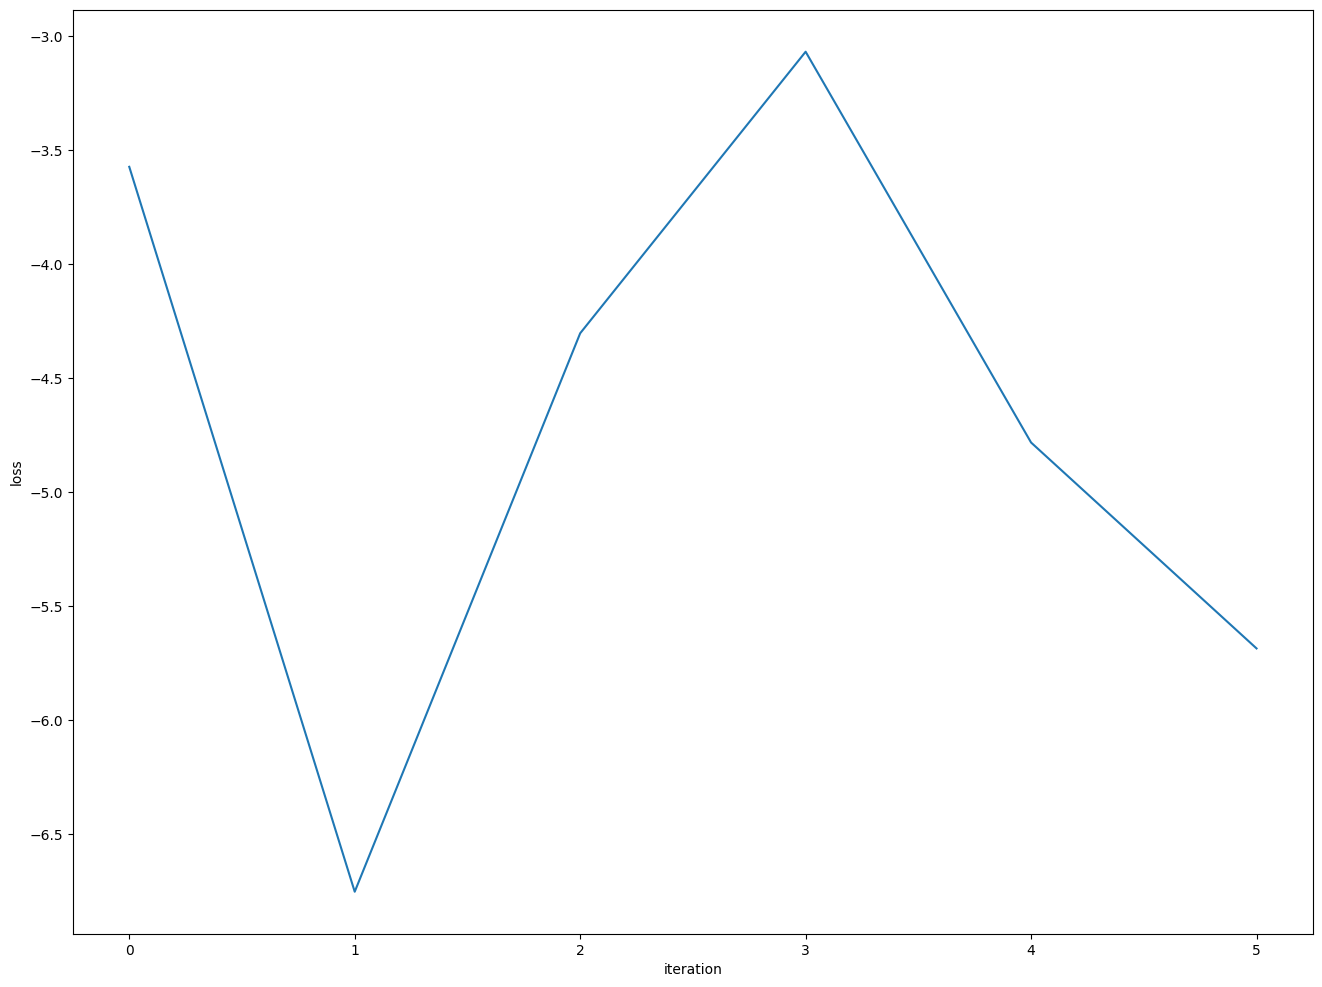

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

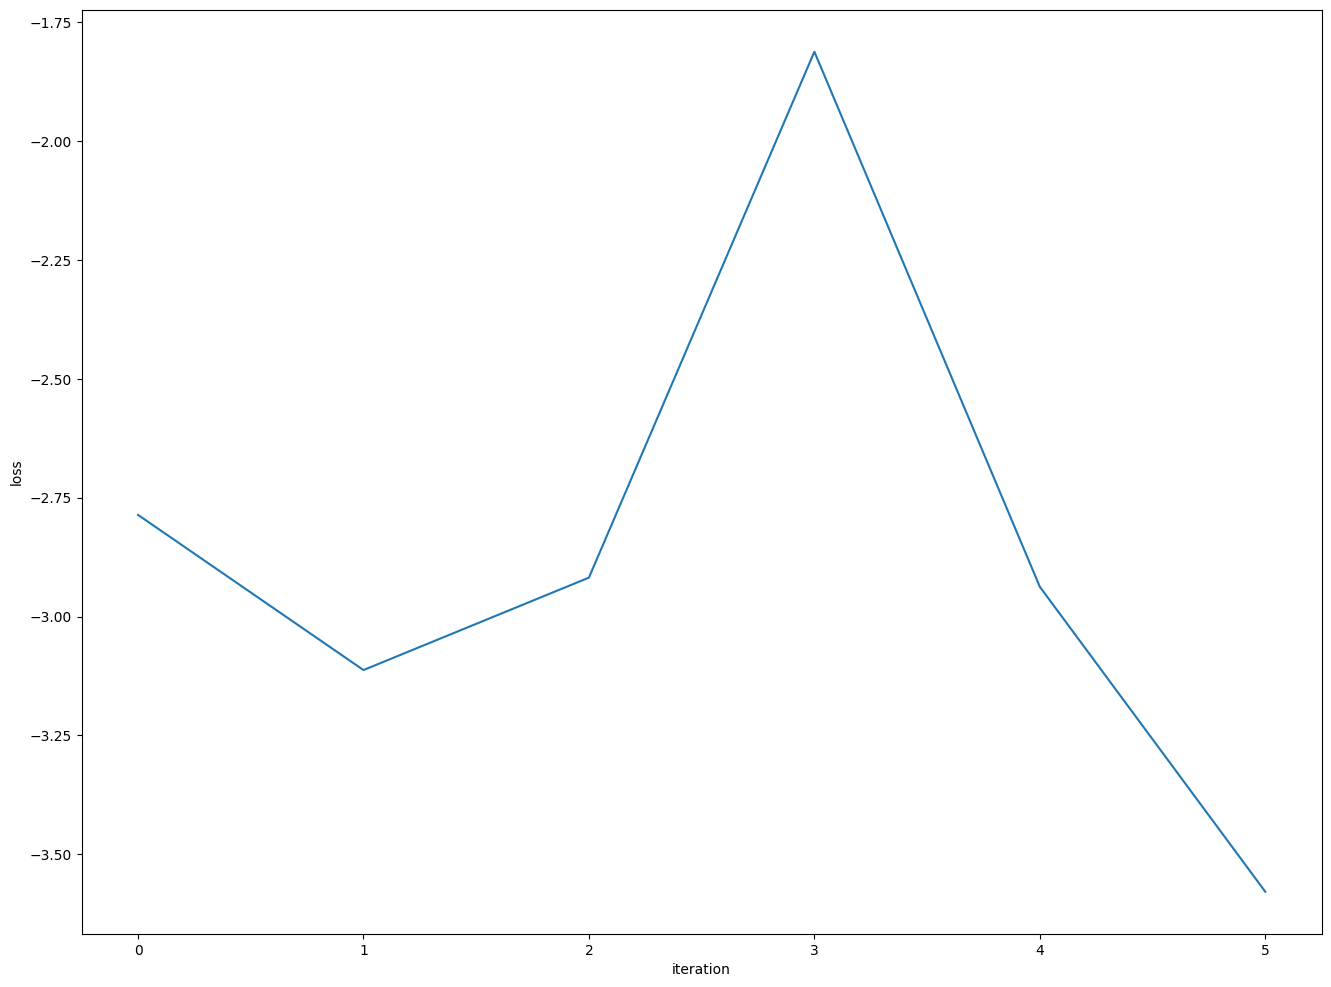

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")